In [2]:
## Import Packages
from __future__ import print_function

import numpy as np
import pandas as pd
from itertools import product

#Astro Software
import astropy.units as units
from astropy.coordinates import SkyCoord
from astropy.io import fits

#Plotting Packages
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import rcParams

import seaborn as sns

from PIL import Image

from yt.config import ytcfg
import yt
import yt.units as u

#Scattering NN
import torch
import torch.nn.functional as F
from torch import optim
from kymatio.torch import Scattering2D
device = "cpu"

#Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.decomposition import PCA, FastICA

import skimage
from skimage import filters

from scipy.optimize import curve_fit
from scipy import linalg
from scipy import stats
from scipy.signal import general_gaussian

#I/O
import h5py
import pickle
import glob
import copy
import time

#Plotting Style
%matplotlib inline
plt.style.use('dark_background')
rcParams['text.usetex'] = False
rcParams['axes.titlesize'] = 20
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['legend.fontsize'] = 12
rcParams['axes.labelsize'] = 20
rcParams['font.family'] = 'sans-serif'

#Threading
torch.set_num_threads=2
from multiprocessing import Pool

import ntpath
def path_leaf(path):
    head, tail = ntpath.split(path)
    out = os.path.splitext(tail)[0]
    return out

def hd5_open(file_name,name):
    f=h5py.File(file_name,'r', swmr=True)
    data = f[name][:]
    f.close()
    return data

from matplotlib.colors import LinearSegmentedColormap
cdict1 = {'red':   ((0.0, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 1.0, 1.0)),

         'green': ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),

         'blue':  ((0.0, 0.0, 1.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 0.0, 0.0))
        }
blue_red1 = LinearSegmentedColormap('BlueRed1', cdict1,N=5000)

from sklearn.preprocessing import StandardScaler

/opt/miniconda3/envs/IWST/lib/python3.8/_collections_abc.py:666: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  self[key]


In [3]:
mnist_train_y = hd5_open('../../DHC/scratch_AKS/data/mnist_train_y.h5','main/data')
mnist_test_y = hd5_open('../../DHC/scratch_AKS/data/mnist_test_y.h5','main/data')

In [4]:
mnist_DHC_out_sizetrain = hd5_open('../from_cannon/2021_01_21/mnist_DHC_train_ang_1_1.h5','main/data')
mnist_DHC_out_sizetest = hd5_open('../from_cannon/2021_01_21/mnist_DHC_test_ang_1_1.h5','main/data')

In [73]:
M = 100
angle_train = np.tile([2*np.pi/M,np.pi/3,2*np.pi/3,3*np.pi/3,4*np.pi/3,5*np.pi/3],60000)
angle_array = [i for i in np.linspace(2*np.pi/M,2*np.pi,M)]
angle_test = np.tile(angle_array,10000)
angle_class = np.repeat(mnist_test_y,100)

In [6]:
from sklearn.linear_model import LinearRegression

In [8]:
sc = StandardScaler()
X_tr = sc.fit_transform(np.log10(mnist_DHC_out_sizetest[np.isin(angle_test,angle_array[1:50:2])]))
Y_tr = np.array([np.cos(np.mod(angle_test[np.isin(angle_test,angle_array[1:50:2])],np.pi)),np.sin(np.mod(angle_test[np.isin(angle_test,angle_array[1:50:2])],np.pi))]).T
Y_test = np.array([np.cos(np.mod(angle_test[np.isin(angle_test,angle_array[0:50:2])],np.pi)),np.sin(np.mod(angle_test[np.isin(angle_test,angle_array[0:50:2])],np.pi))]).T
X_test = sc.transform(np.log10(mnist_DHC_out_sizetest[np.isin(angle_test,angle_array[0:50:2])]))

reg = LinearRegression().fit(X_tr, Y_tr)
y_pred_test = reg.predict(X_test)
y_pred_train = reg.predict(X_tr)
train_lossl2 = np.mean(np.square(y_pred_train-Y_tr))
test_lossl2 = np.mean(np.square(y_pred_test-Y_test))

train_lossl2,test_lossl2

(0.0750567036566669, 0.08122712975157201)

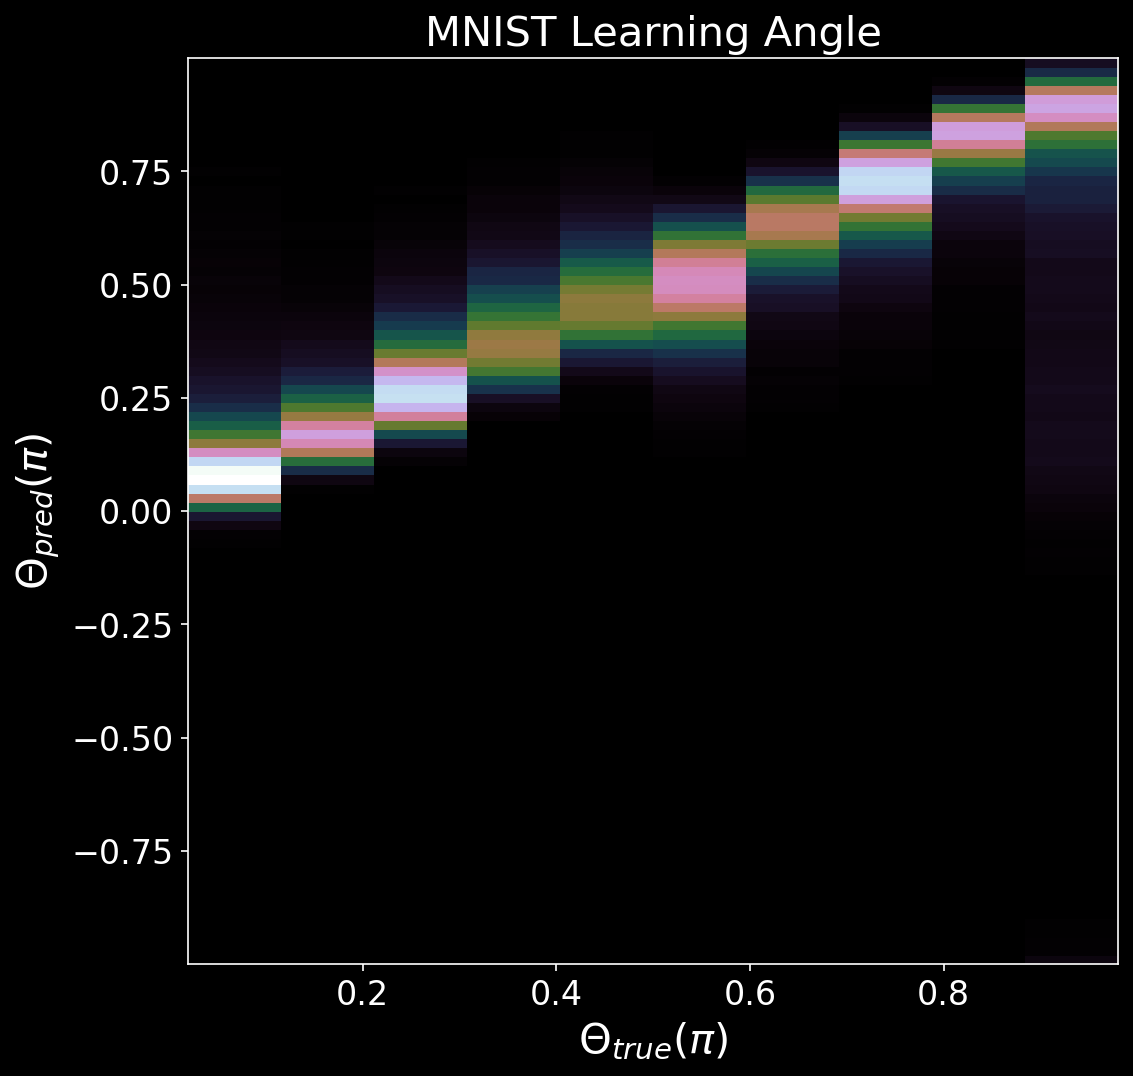

In [9]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111) 
#plt.scatter(Y_test,np.square(y_pred_test-Y_test),s=1)
ax.hist2d(np.arctan2(Y_test[:,1],Y_test[:,0])/np.pi, np.arctan2(y_pred_test[:,1],y_pred_test[:,0])/np.pi, 
          bins=[10,100],cmap='cubehelix')
#plt.ylim([-1.1,1.1])
#for i in np.array((np.mod([2*np.pi/M,np.pi/3,2*np.pi/3,3*np.pi/3,4*np.pi/3,5*np.pi/3],np.pi)-0.5)/np.pi):
#    plt.vlines(i,-2,2,'w')

plt.ylabel('$\Theta_{pred} (\pi)$')
plt.xlabel('$\Theta_{true} (\pi)$')
plt.title('MNIST Learning Angle')
plt.show()

In [10]:
sc = StandardScaler()
X_tr = sc.fit_transform(np.log10(mnist_DHC_out_sizetest[np.isin(angle_test,angle_array[1:50:2])]))
Y_tr = np.array([np.cos(2*np.mod(angle_test[np.isin(angle_test,angle_array[1:50:2])],np.pi)),np.sin(2*np.mod(angle_test[np.isin(angle_test,angle_array[1:50:2])],np.pi))]).T
Y_test = np.array([np.cos(2*np.mod(angle_test[np.isin(angle_test,angle_array[0:50:2])],np.pi)),np.sin(2*np.mod(angle_test[np.isin(angle_test,angle_array[0:50:2])],np.pi))]).T
X_test = sc.transform(np.log10(mnist_DHC_out_sizetest[np.isin(angle_test,angle_array[0:50:2])]))

reg = LinearRegression().fit(X_tr, Y_tr)
y_pred_test = reg.predict(X_test)
y_pred_train = reg.predict(X_tr)
train_lossl2 = np.mean(np.square(y_pred_train-Y_tr))
test_lossl2 = np.mean(np.square(y_pred_test-Y_test))

train_lossl2,test_lossl2

(0.0996000702337984, 0.0997173241402614)

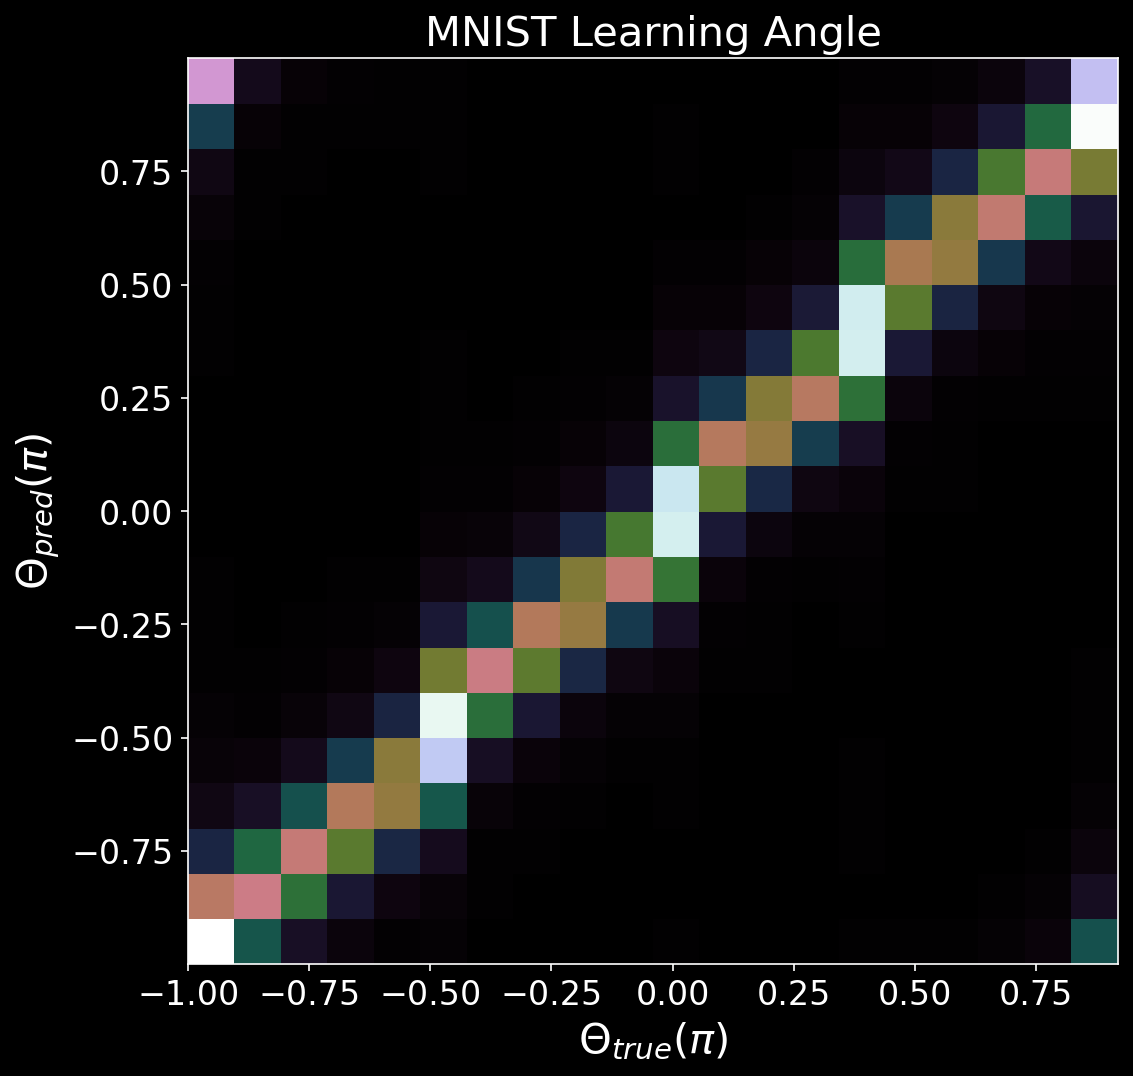

In [26]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111) 
#plt.scatter(Y_test,np.square(y_pred_test-Y_test),s=1)
ax.hist2d(np.arctan2(Y_test[:,1],Y_test[:,0])/np.pi, np.arctan2(y_pred_test[:,1],y_pred_test[:,0])/np.pi, 
          bins=[20,20],cmap='cubehelix')
#plt.ylim([-1.1,1.1])
#for i in np.array((np.mod([2*np.pi/M,np.pi/3,2*np.pi/3,3*np.pi/3,4*np.pi/3,5*np.pi/3],np.pi)-0.5)/np.pi):
#    plt.vlines(i,-2,2,'w')

plt.ylabel('$\Theta_{pred} (\pi)$')
plt.xlabel('$\Theta_{true} (\pi)$')
plt.title('MNIST Learning Angle')
plt.show()

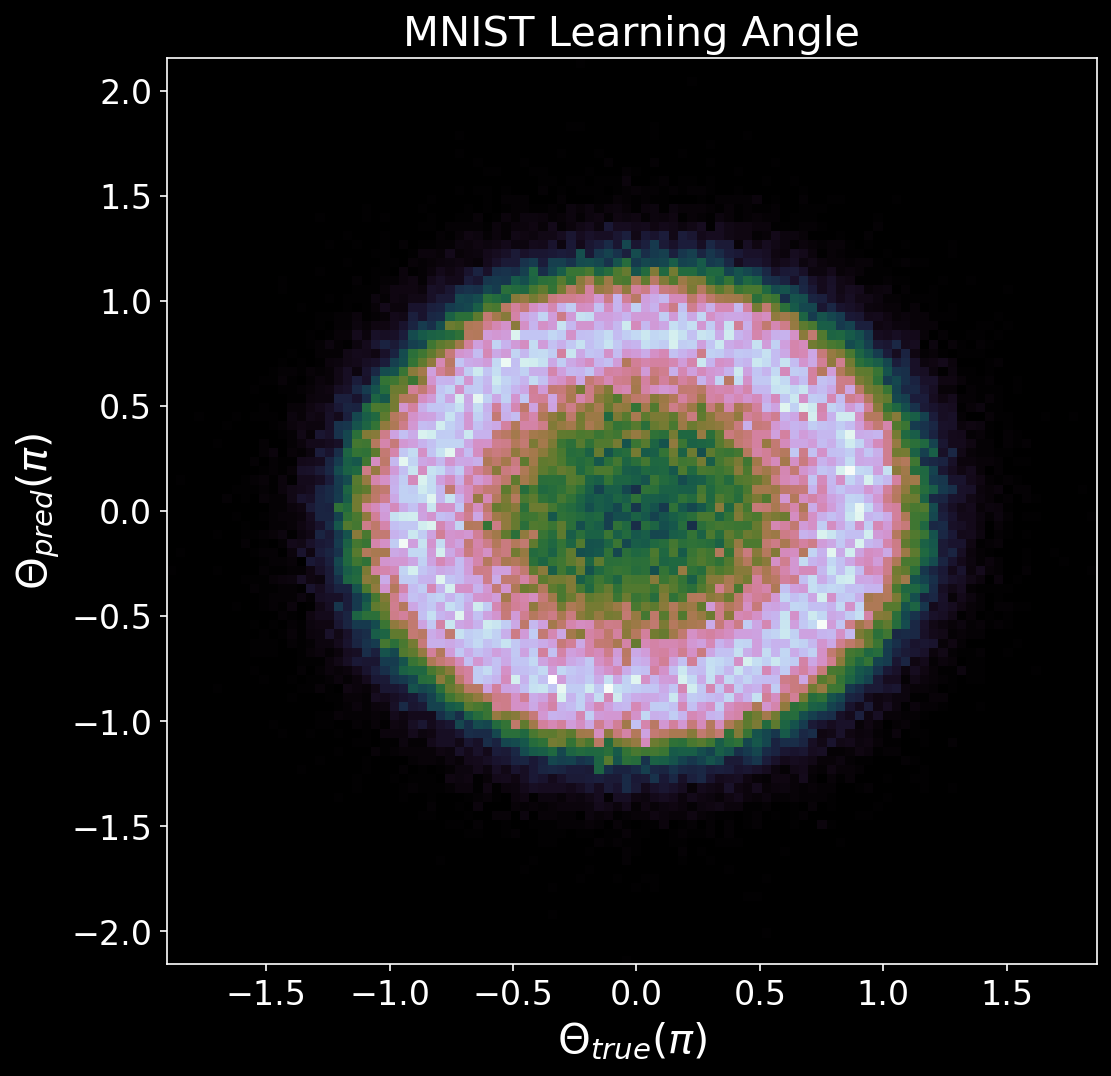

In [27]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111) 
#plt.scatter(Y_test,np.square(y_pred_test-Y_test),s=1)
ax.hist2d(y_pred_test[:,0], y_pred_test[:,1],
          bins=[100,100],cmap='cubehelix')
#plt.ylim([-1.1,1.1])
#for i in np.array((np.mod([2*np.pi/M,np.pi/3,2*np.pi/3,3*np.pi/3,4*np.pi/3,5*np.pi/3],np.pi)-0.5)/np.pi):
#    plt.vlines(i,-2,2,'w')

plt.ylabel('$\Theta_{pred} (\pi)$')
plt.xlabel('$\Theta_{true} (\pi)$')
plt.title('MNIST Learning Angle')
plt.show()

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import sklearn.datasets
import umap
import umap.plot
import datashader as ds, pandas as pd, colorcet as cc

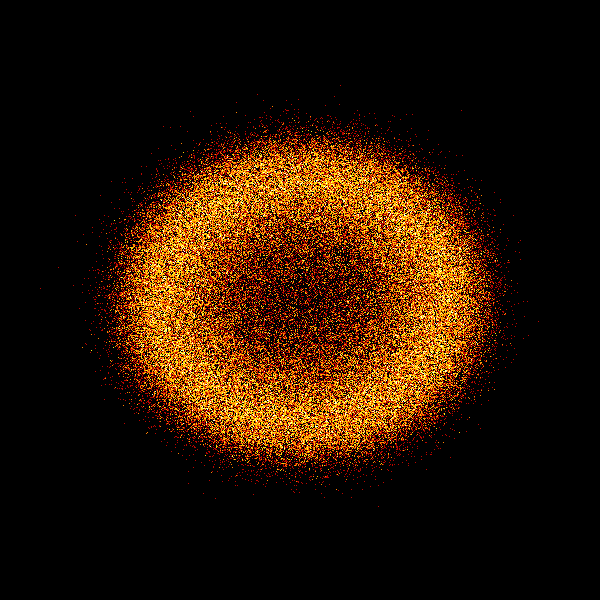

In [28]:
pd_v = pd.DataFrame(data=y_pred_test,columns=["x", "y"])
agg = ds.Canvas().points(pd_v,'x','y')
ds.tf.set_background(ds.tf.shade(agg, cmap=cc.fire), "black")

/opt/miniconda3/envs/IWST/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

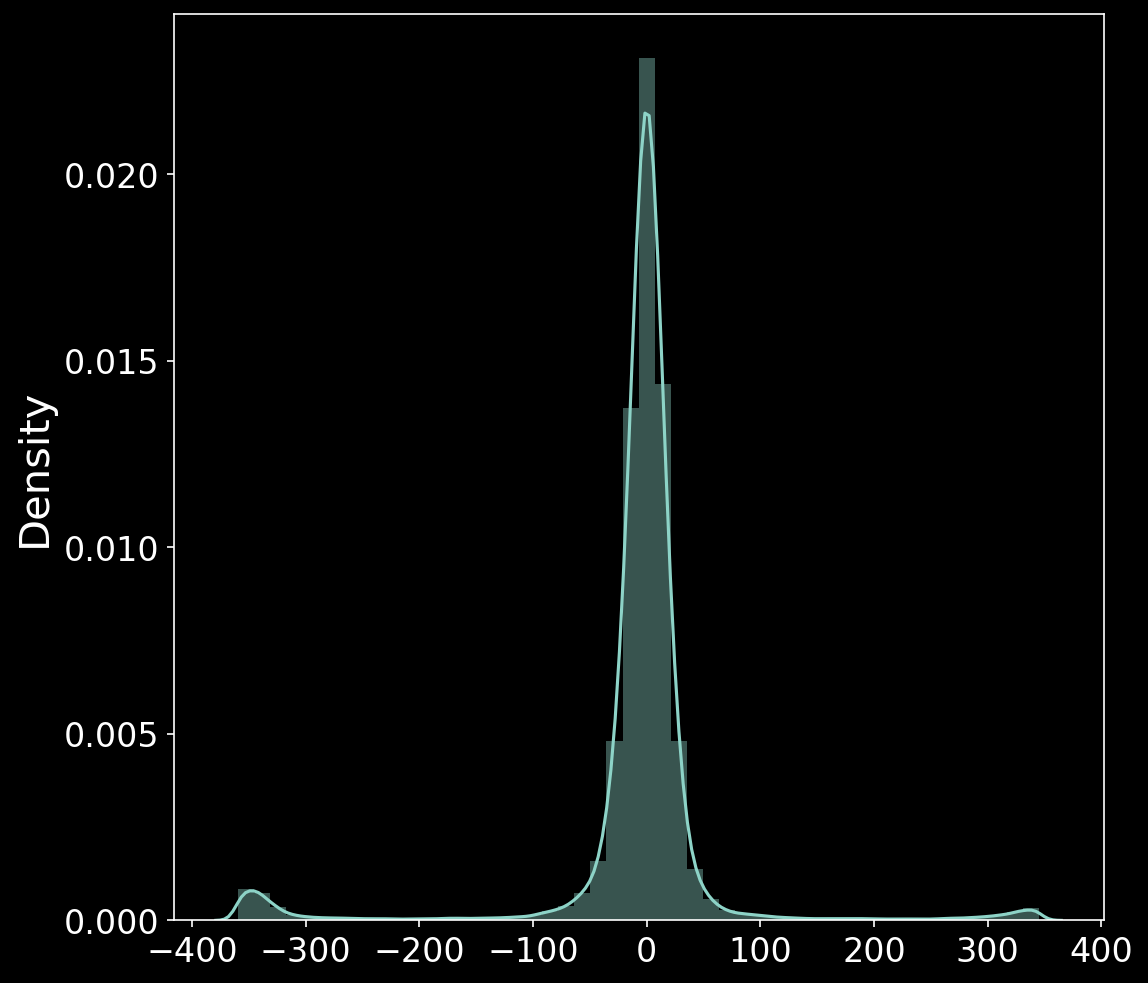

In [42]:
fig = plt.figure(figsize=(8,8),dpi=150)
sns.distplot(diff)

In [41]:
diff = 180*(np.arctan2(Y_test[:,1],Y_test[:,0])/np.pi-np.arctan2(y_pred_test[:,1],y_pred_test[:,0])/np.pi)

In [43]:
diff[diff<-180]+=360
diff[diff>180]-=360

/opt/miniconda3/envs/IWST/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

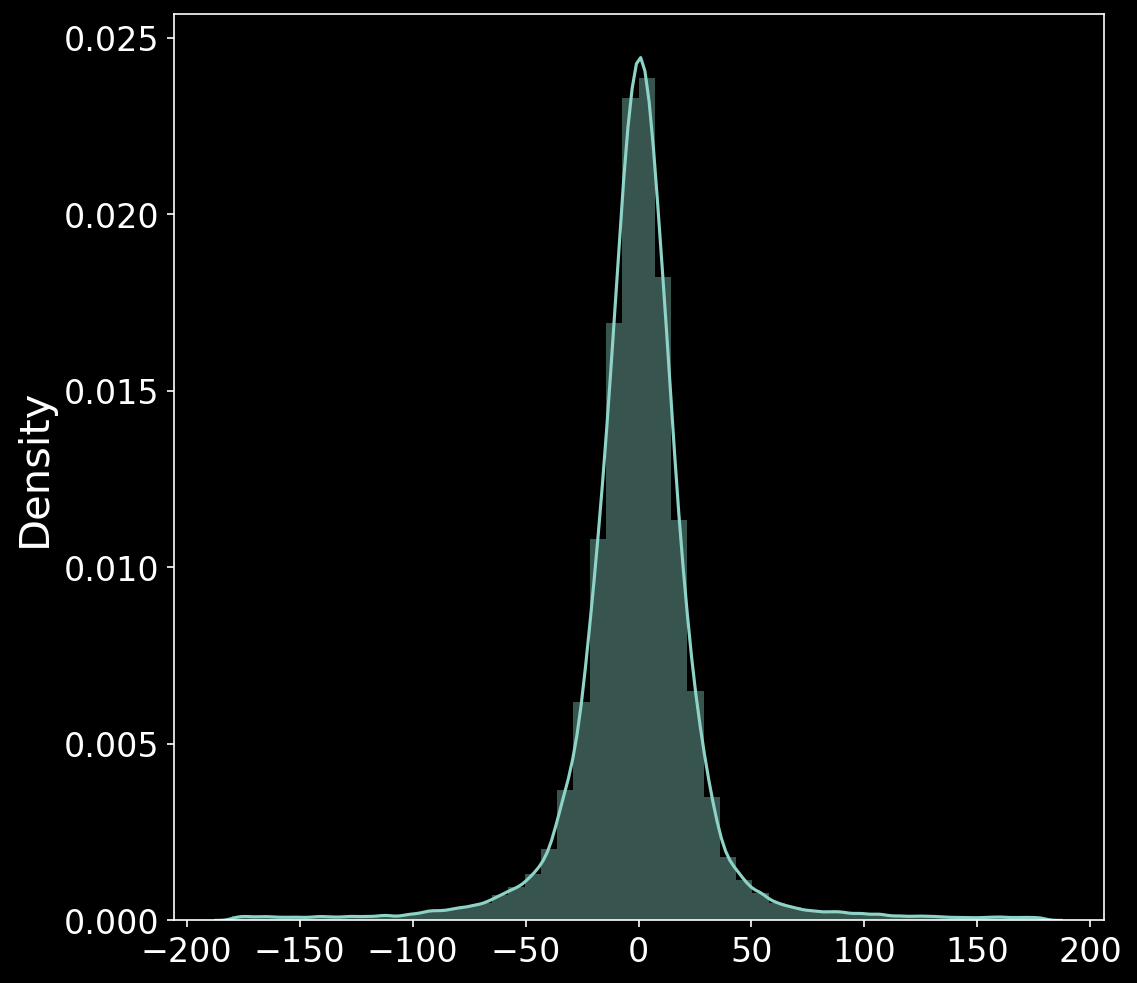

In [44]:
fig = plt.figure(figsize=(8,8),dpi=150)
sns.distplot(diff)

In [45]:
np.std(diff)

28.522497735468068

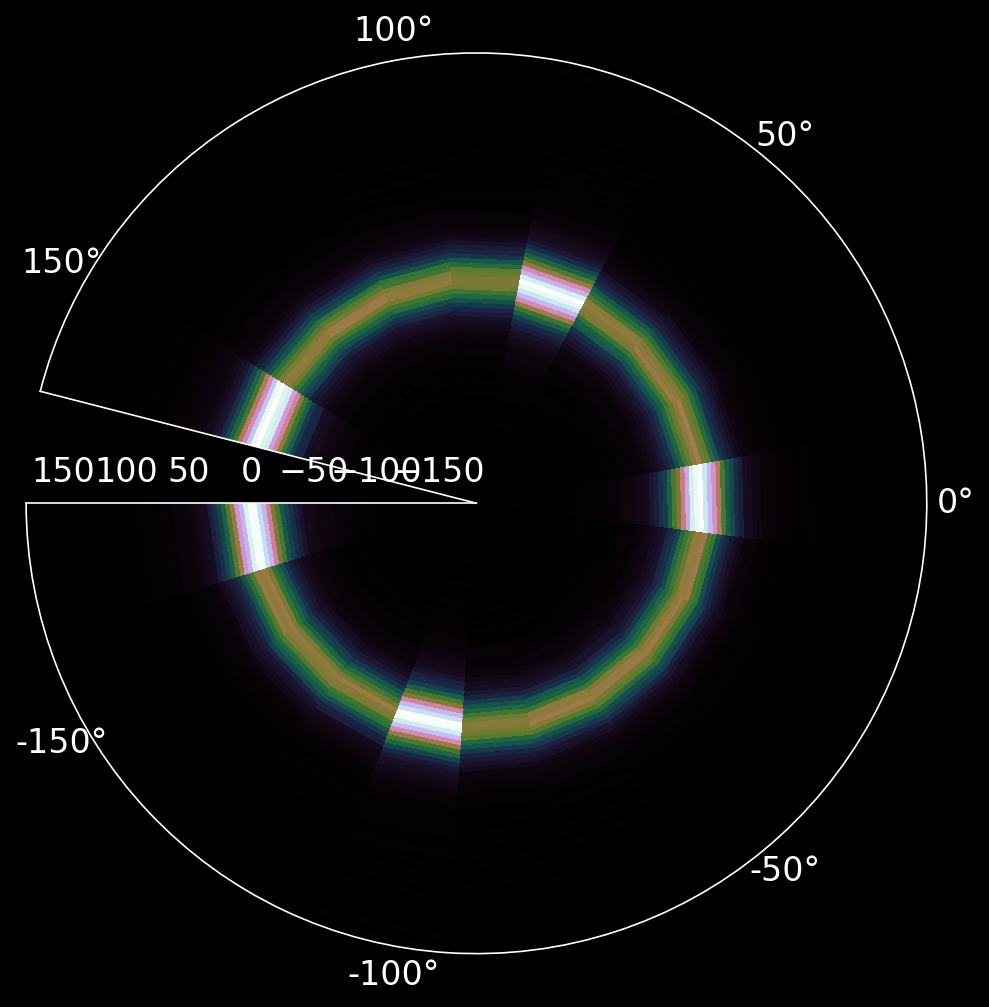

In [50]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111,projection='polar') 
ax.hist2d(np.arctan2(Y_test[:,1],Y_test[:,0]), diff, bins=[20,100],cmap='cubehelix')
plt.show()

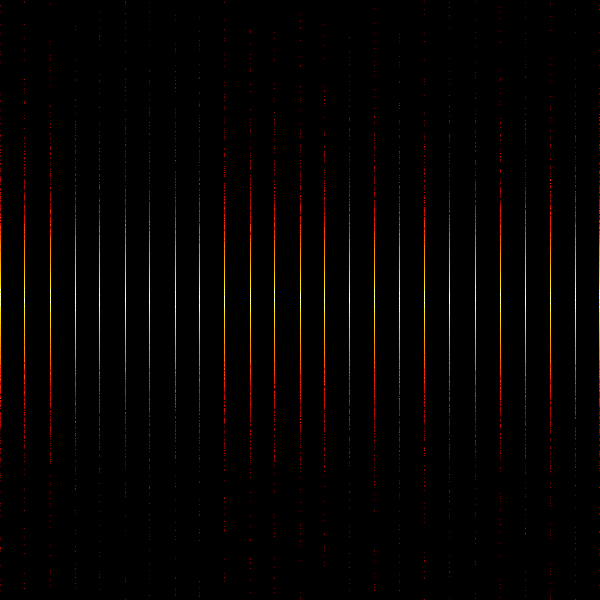

In [72]:
pd_v = pd.DataFrame(data=np.stack((np.arctan2(Y_test[:,1],Y_test[:,0]),diff),axis=0).T,columns=["x", "y"])
agg = ds.Canvas().points(pd_v,'x','y')
ds.tf.set_background(ds.tf.shade(agg, cmap=cc.fire), "black")

In [71]:
np.stack((np.arctan2(Y_test[:,1],Y_test[:,0]),diff),axis=0).T.shape

(250000, 2)

In [77]:
angle_class[np.isin(angle_test,angle_array[0:50:2])].shape

(250000,)

In [85]:
zero = np.isin(angle_class[np.isin(angle_test,angle_array[0:50:2])],0)
one = np.isin(angle_class[np.isin(angle_test,angle_array[0:50:2])],1)

In [86]:
np.std(diff),np.std(diff[zero]),np.std(diff[one])

(28.522497735468068, 47.26016815400148, 18.22104983254627)

In [88]:
std_class = []
for i in range(10):
    maskt = np.isin(angle_class[np.isin(angle_test,angle_array[0:50:2])],i)
    std_class.append(np.std(diff[maskt]))

In [89]:
std_class

[47.26016815400148,
 18.22104983254627,
 27.884098181194965,
 18.44869592814563,
 33.11285746424484,
 33.80116644797987,
 25.738056189178767,
 20.98236339763592,
 22.372498694523188,
 23.492687939897927]

In [109]:
std_class = np.zeros((8,13))
for i in range(2,9):
    print(i)
    sc = StandardScaler()
    tr_slice = np.isin(angle_test,angle_array[1:50:i])
    tst_slice = ~tr_slice
    X_tr = sc.fit_transform(np.log10(mnist_DHC_out_sizetest[tr_slice]))
    Y_tr = np.array([np.cos(2*np.mod(angle_test[tr_slice],np.pi)),np.sin(2*np.mod(angle_test[tr_slice],np.pi))]).T
    Y_test = np.array([np.cos(2*np.mod(angle_test[tst_slice],np.pi)),np.sin(2*np.mod(angle_test[tst_slice],np.pi))]).T
    X_test = sc.transform(np.log10(mnist_DHC_out_sizetest[tst_slice]))

    reg = LinearRegression().fit(X_tr, Y_tr)
    y_pred_test = reg.predict(X_test)
    y_pred_train = reg.predict(X_tr)
    train_lossl2 = np.mean(np.square(y_pred_train-Y_tr))
    test_lossl2 = np.mean(np.square(y_pred_test-Y_test))
    
    std_class[i-2,0] = train_lossl2
    std_class[i-2,1] = test_lossl2
    
    diff = 180*(np.arctan2(Y_test[:,1],Y_test[:,0])/np.pi-np.arctan2(y_pred_test[:,1],y_pred_test[:,0])/np.pi)
    diff[diff<-180]+=360
    diff[diff>180]-=360
    
    std_class[i-2,2] = np.std(diff)
    
    for j in range(10):
        maskt = np.isin(angle_class[tst_slice],j)
        std_class[i-2,3+j] = np.std(diff[maskt])

2
3
4
5
6
7
8


In [118]:
num_train_angle = []
for i in range(2,9):
    tr_slice = np.isin(angle_test,angle_array[1:50:i])
    num_train_angle.append(np.count_nonzero(tr_slice)/10000)

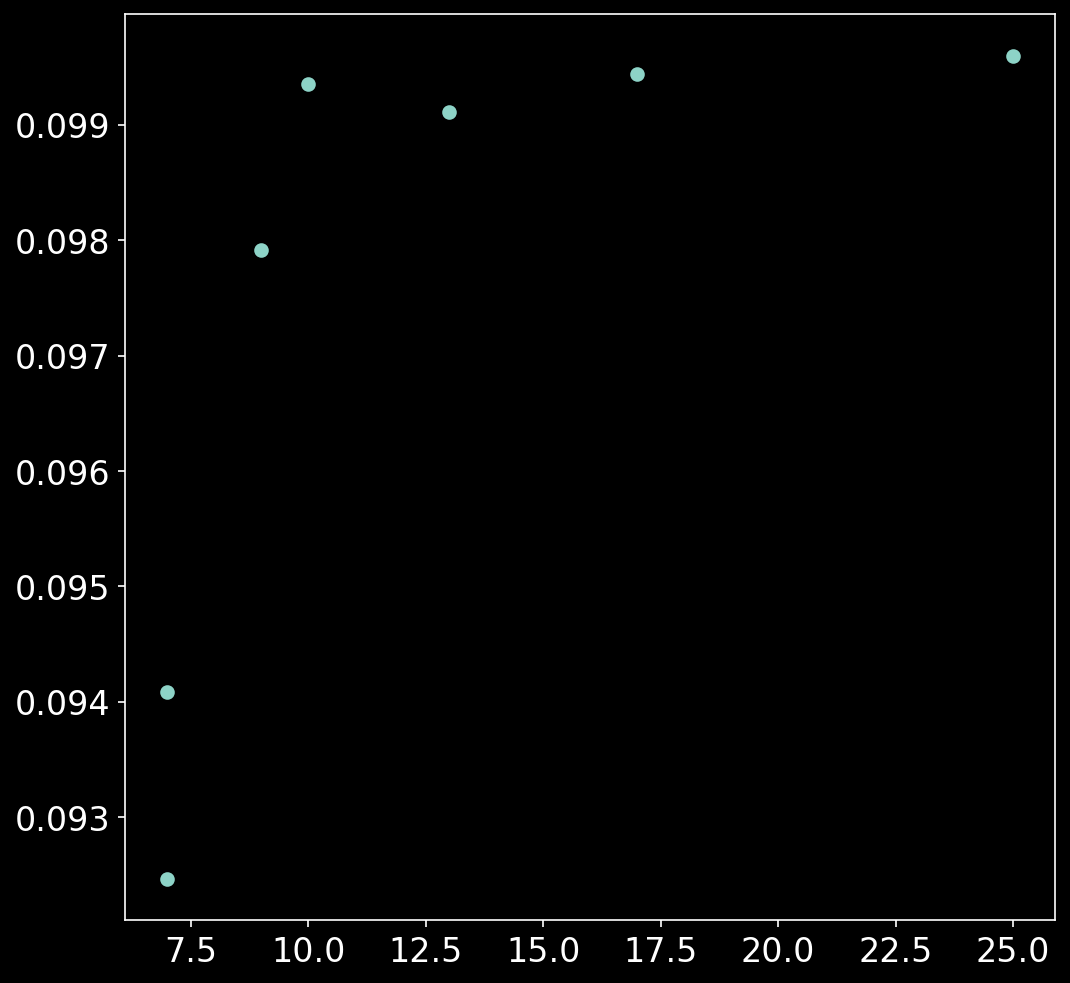

In [120]:
fig = plt.figure(figsize=(8,8),dpi=150)
plt.scatter(num_train_angle,std_class[:-1,0])

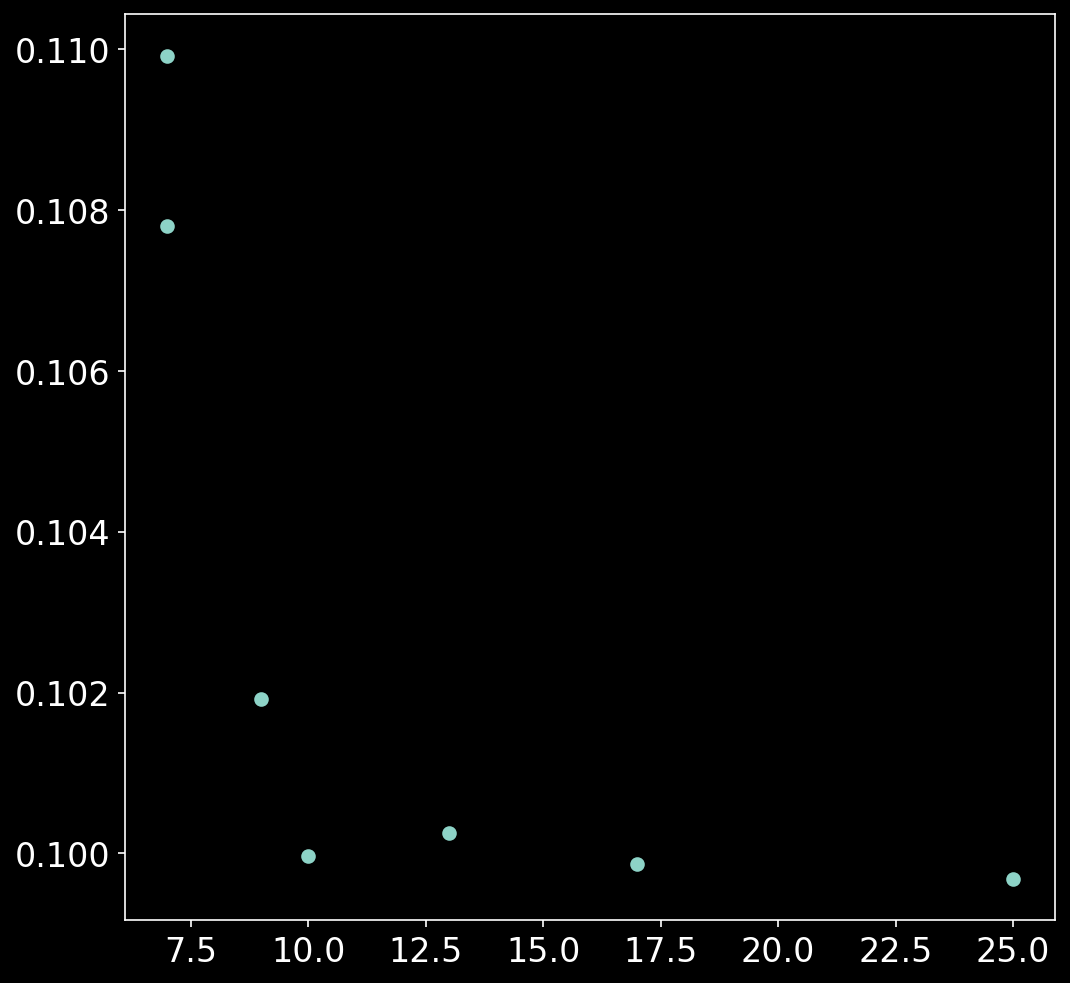

In [121]:
fig = plt.figure(figsize=(8,8),dpi=150)
plt.scatter(num_train_angle,std_class[:-1,1])

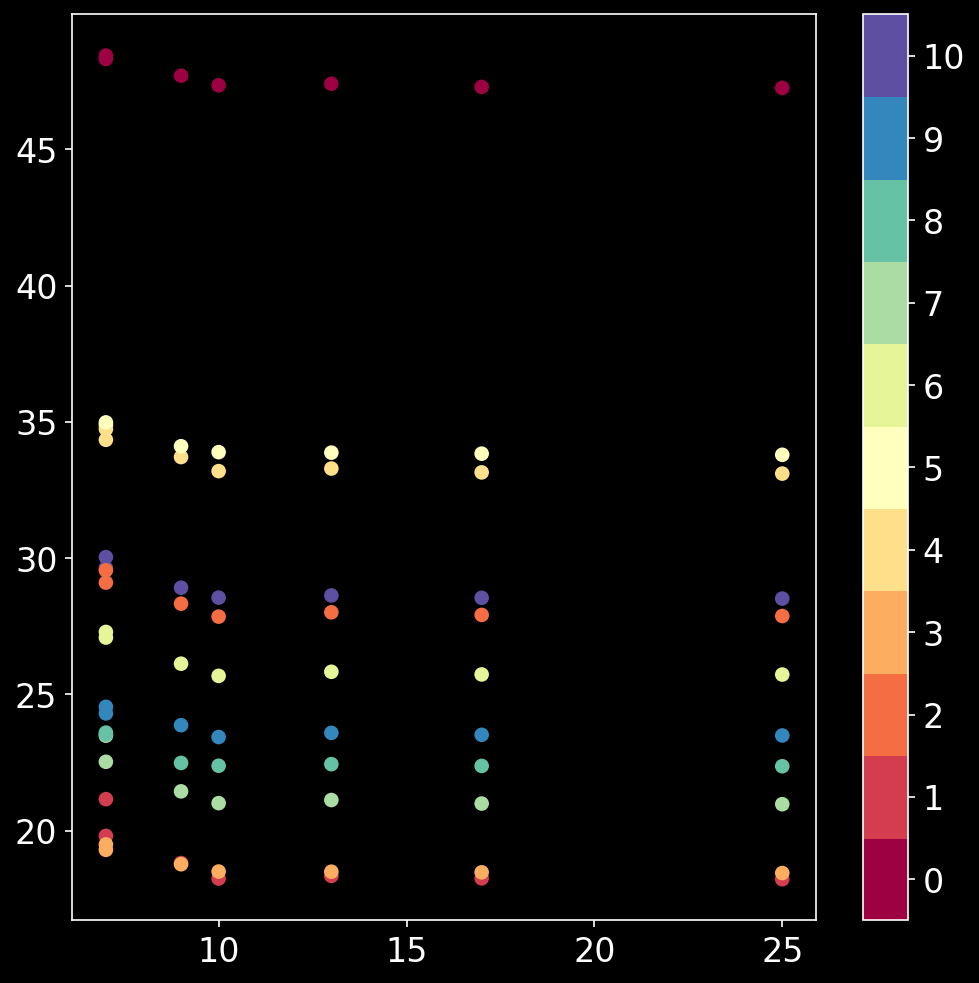

In [142]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111)
for i in range(2,9):
    sc = ax.scatter(num_train_angle[i-2]*np.ones(11),std_class[i-2,2:],c=[10,0,1,2,3,4,5,6,7,8,9],cmap='Spectral',vmin=0,vmax=10)
plt.colorbar(sc,boundaries=np.arange(12)-0.5).set_ticks(np.arange(11))

In [141]:
std_class

array([[ 0.09960007,  0.09967824, 28.51397974, 47.25531268, 18.21493599,
        27.87398666, 18.442303  , 33.10082713, 33.7913265 , 25.72620432,
        20.96898543, 22.36205506, 23.49098676],
       [ 0.09943767,  0.09986399, 28.54241481, 47.29038353, 18.24841918,
        27.91450328, 18.46863787, 33.14522655, 33.83289833, 25.73031976,
        20.99239731, 22.37319168, 23.51466667],
       [ 0.09910783,  0.10025139, 28.62913333, 47.40741988, 18.33778417,
        28.01057938, 18.49146377, 33.28568111, 33.86968668, 25.82782207,
        21.12141217, 22.43812928, 23.58596935],
       [ 0.09935555,  0.09997044, 28.55006473, 47.34872207, 18.24125837,
        27.85254215, 18.49705776, 33.19207879, 33.88827205, 25.6784463 ,
        21.00791385, 22.37960507, 23.43356075],
       [ 0.0979113 ,  0.10191839, 28.91310872, 47.70311632, 18.80772214,
        28.3279298 , 18.76542452, 33.70823083, 34.10482563, 26.12477404,
        21.43977265, 22.48269948, 23.86783452],
       [ 0.09408827,  0.107797

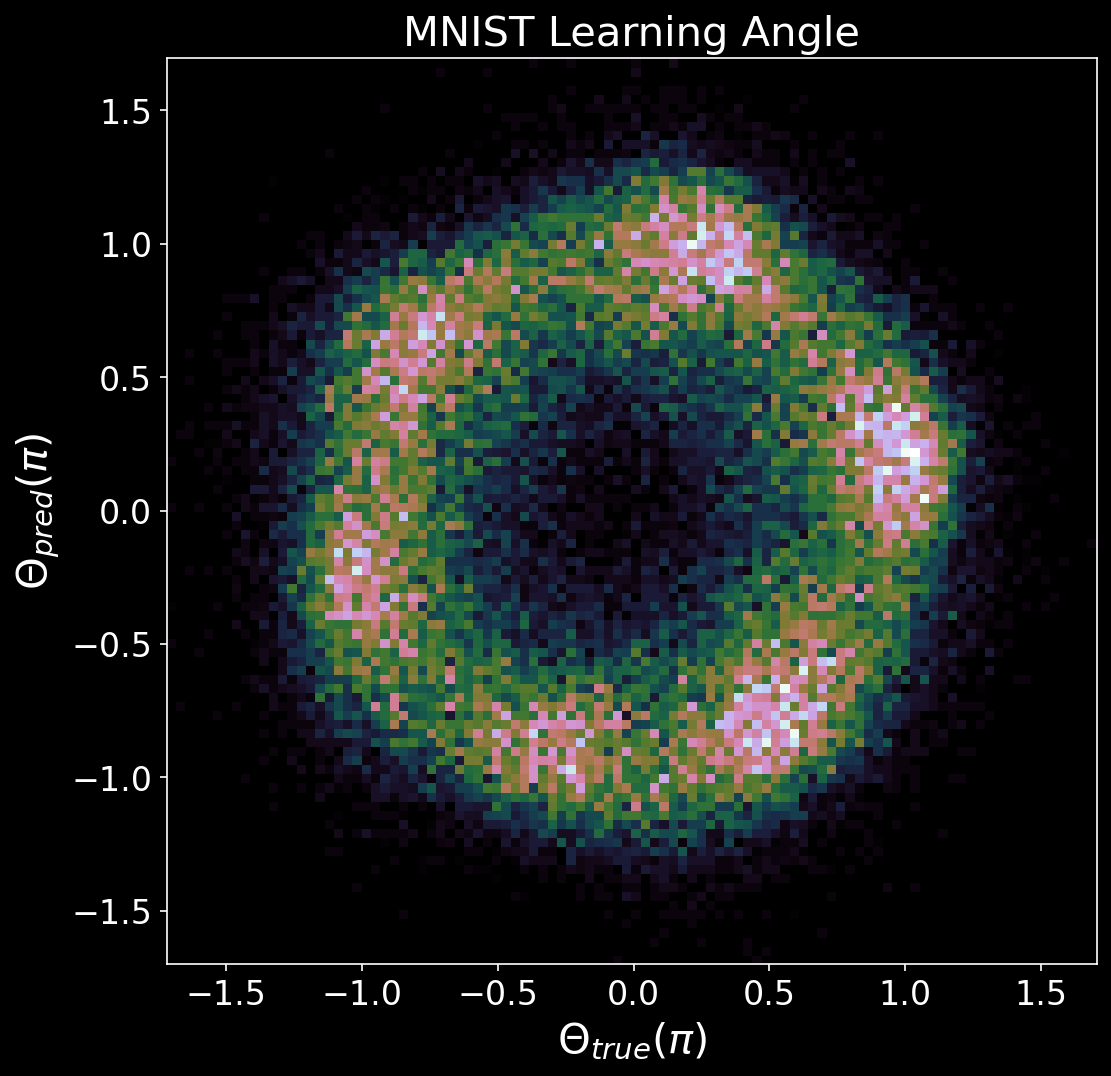

In [144]:
maskt = np.isin(angle_class[tst_slice],1)

fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111) 
#plt.scatter(Y_test,np.square(y_pred_test-Y_test),s=1)
ax.hist2d(y_pred_test[maskt,0], y_pred_test[maskt,1],
          bins=[100,100],cmap='cubehelix')
#plt.ylim([-1.1,1.1])
#for i in np.array((np.mod([2*np.pi/M,np.pi/3,2*np.pi/3,3*np.pi/3,4*np.pi/3,5*np.pi/3],np.pi)-0.5)/np.pi):
#    plt.vlines(i,-2,2,'w')

plt.ylabel('$\Theta_{pred} (\pi)$')
plt.xlabel('$\Theta_{true} (\pi)$')
plt.title('MNIST Learning Angle')
plt.show()

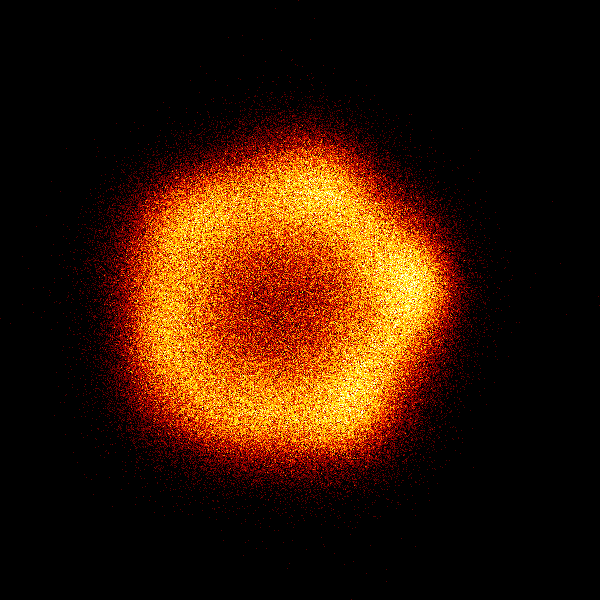

In [145]:
pd_v = pd.DataFrame(data=y_pred_test,columns=["x", "y"])
agg = ds.Canvas().points(pd_v,'x','y')
ds.tf.set_background(ds.tf.shade(agg, cmap=cc.fire), "black")

In [146]:
i=4
sc = StandardScaler()
tr_slice = np.isin(angle_test,angle_array[1:50:i])
tst_slice = ~tr_slice
X_tr = sc.fit_transform(np.log10(mnist_DHC_out_sizetest[tr_slice]))
Y_tr = np.array([np.cos(2*np.mod(angle_test[tr_slice],np.pi)),np.sin(2*np.mod(angle_test[tr_slice],np.pi))]).T
Y_test = np.array([np.cos(2*np.mod(angle_test[tst_slice],np.pi)),np.sin(2*np.mod(angle_test[tst_slice],np.pi))]).T
X_test = sc.transform(np.log10(mnist_DHC_out_sizetest[tst_slice]))

reg = LinearRegression().fit(X_tr, Y_tr)
y_pred_test = reg.predict(X_test)
y_pred_train = reg.predict(X_tr)
train_lossl2 = np.mean(np.square(y_pred_train-Y_tr))
test_lossl2 = np.mean(np.square(y_pred_test-Y_test))

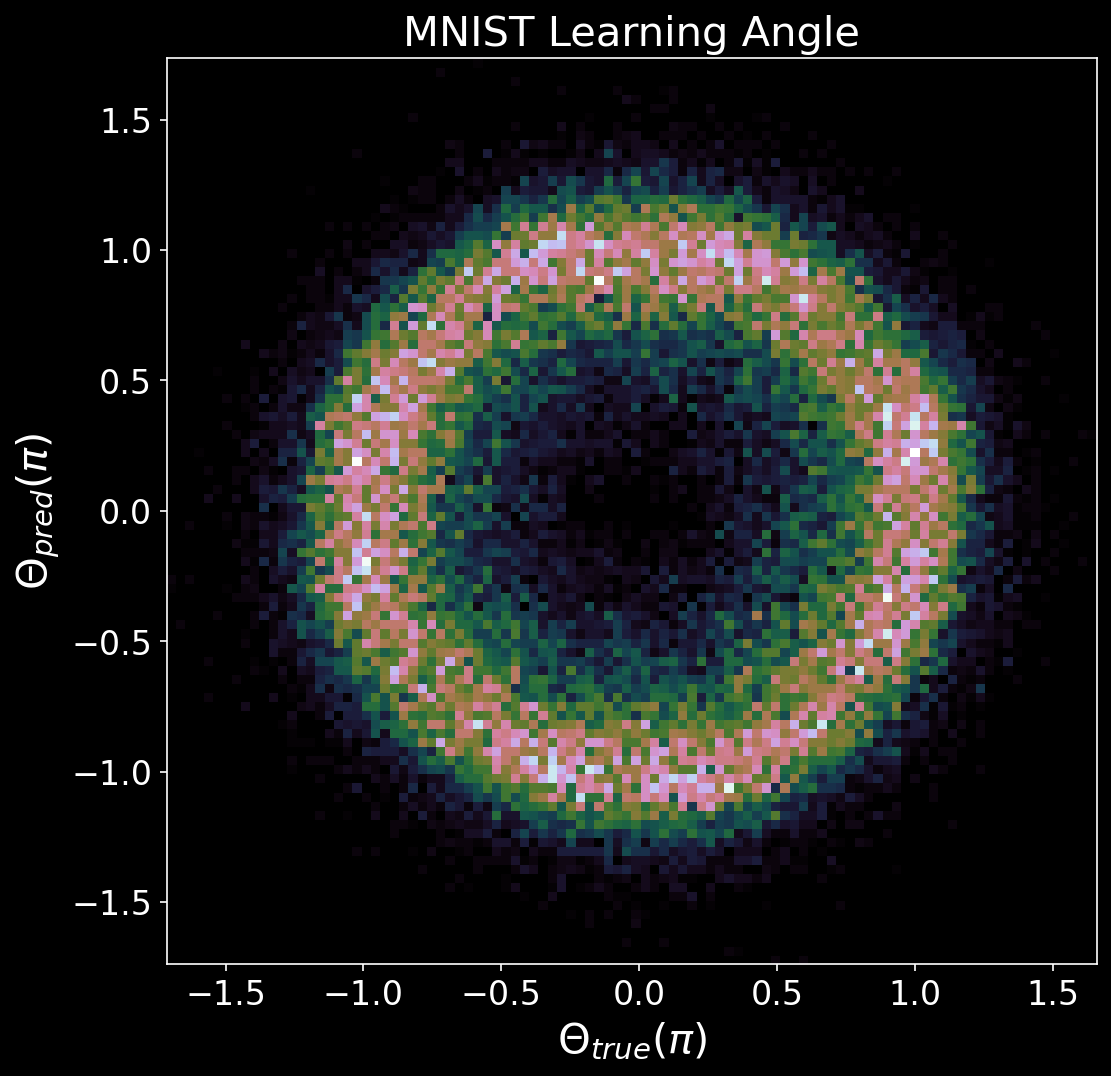

In [147]:
maskt = np.isin(angle_class[tst_slice],1)

fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111) 
#plt.scatter(Y_test,np.square(y_pred_test-Y_test),s=1)
ax.hist2d(y_pred_test[maskt,0], y_pred_test[maskt,1],
          bins=[100,100],cmap='cubehelix')
#plt.ylim([-1.1,1.1])
#for i in np.array((np.mod([2*np.pi/M,np.pi/3,2*np.pi/3,3*np.pi/3,4*np.pi/3,5*np.pi/3],np.pi)-0.5)/np.pi):
#    plt.vlines(i,-2,2,'w')

plt.ylabel('$\Theta_{pred} (\pi)$')
plt.xlabel('$\Theta_{true} (\pi)$')
plt.title('MNIST Learning Angle')
plt.show()

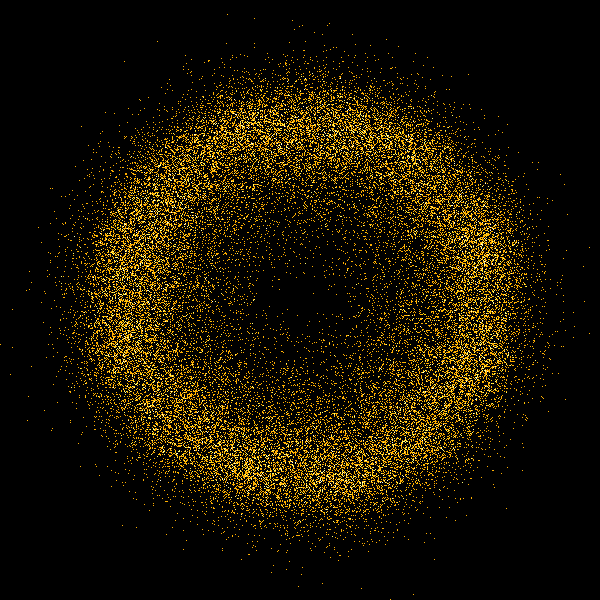

In [148]:
pd_v = pd.DataFrame(data=y_pred_test[maskt],columns=["x", "y"])
agg = ds.Canvas().points(pd_v,'x','y')
ds.tf.set_background(ds.tf.shade(agg, cmap=cc.fire), "black")

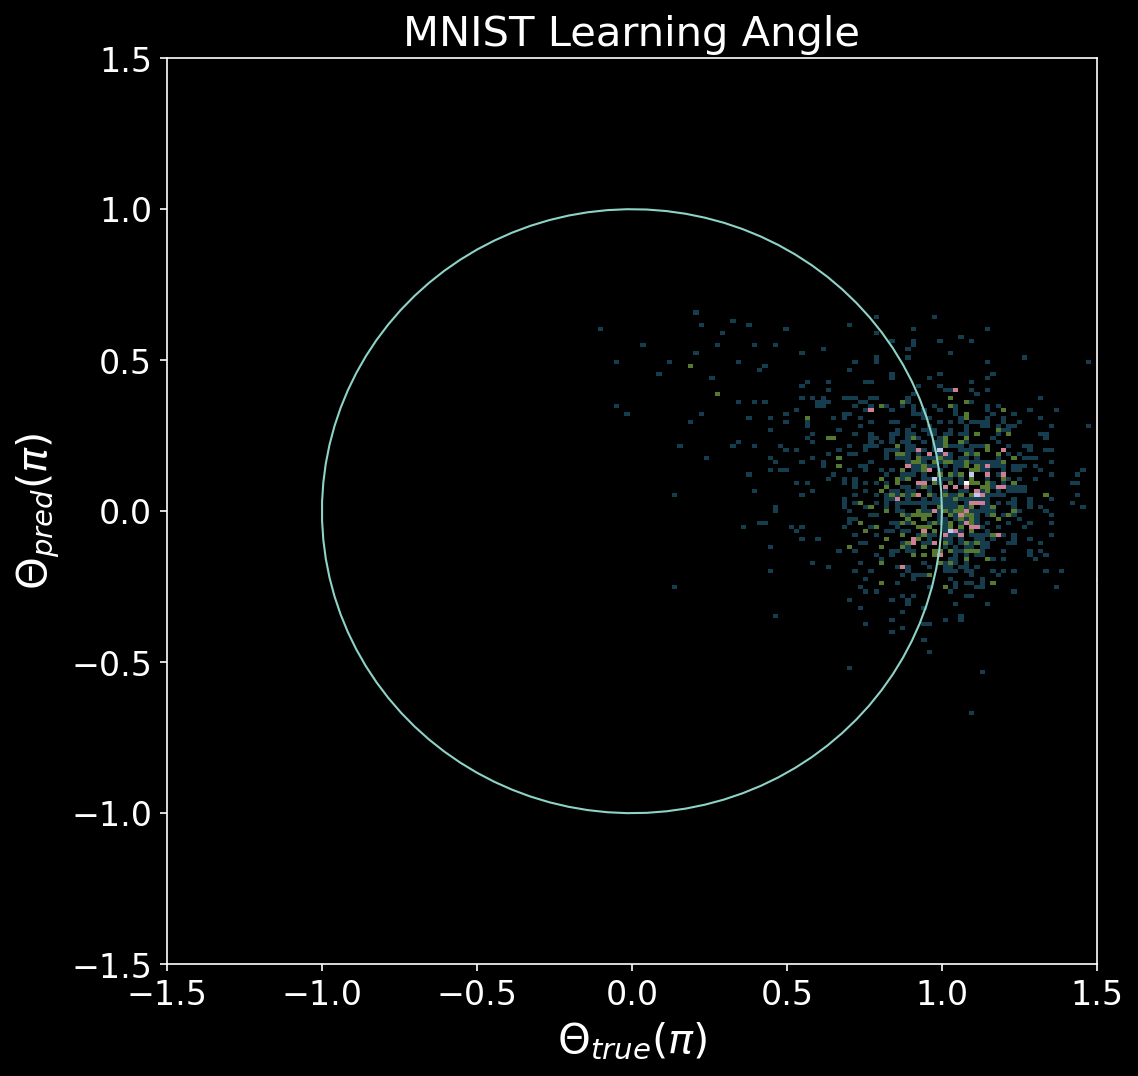

In [155]:
maskt = np.logical_and(np.isin(angle_class[tst_slice],1),np.isin(angle_test[tst_slice],angle_test[0]))

fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111) 
ax.hist2d(y_pred_test[maskt,0], y_pred_test[maskt,1],
          bins=[100,100],cmap='cubehelix')
plt.xlim([-1.5,1.5])
plt.ylim([-1.5,1.5])
t = np.linspace(0,np.pi*2,100)
ax.plot(np.cos(t), np.sin(t), linewidth=1)
plt.ylabel('$\Theta_{pred} (\pi)$')
plt.xlabel('$\Theta_{true} (\pi)$')
plt.title('MNIST Learning Angle')
plt.show()

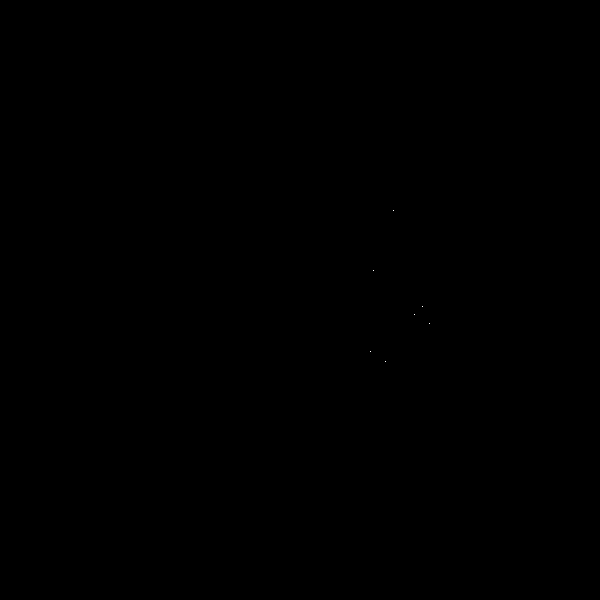

In [153]:
pd_v = pd.DataFrame(data=y_pred_test[maskt],columns=["x", "y"])
agg = ds.Canvas().points(pd_v,'x','y')
ds.tf.set_background(ds.tf.shade(agg, cmap=cc.fire), "black")

In [156]:
i=4
sc = StandardScaler()
tr_slice = np.logical_and(np.isin(angle_test,angle_array[1:50:i]),np.isin(angle_class,1))
tst_slice = np.logical_and(~tr_slice,np.isin(angle_class,1))
X_tr = sc.fit_transform(np.log10(mnist_DHC_out_sizetest[tr_slice]))
Y_tr = np.array([np.cos(2*np.mod(angle_test[tr_slice],np.pi)),np.sin(2*np.mod(angle_test[tr_slice],np.pi))]).T
Y_test = np.array([np.cos(2*np.mod(angle_test[tst_slice],np.pi)),np.sin(2*np.mod(angle_test[tst_slice],np.pi))]).T
X_test = sc.transform(np.log10(mnist_DHC_out_sizetest[tst_slice]))

reg = LinearRegression().fit(X_tr, Y_tr)
y_pred_test = reg.predict(X_test)
y_pred_train = reg.predict(X_tr)
train_lossl2 = np.mean(np.square(y_pred_train-Y_tr))
test_lossl2 = np.mean(np.square(y_pred_test-Y_test))

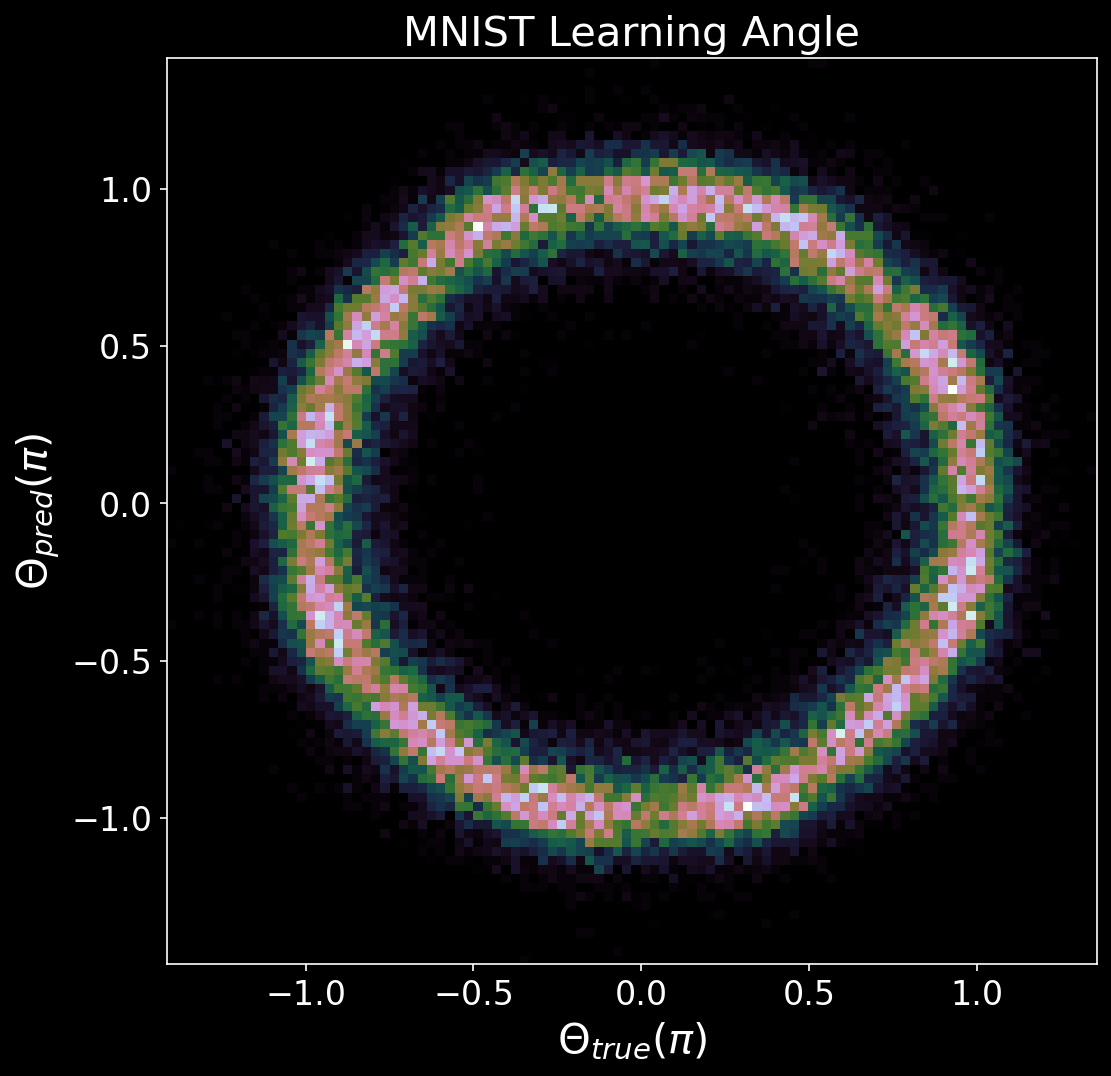

In [158]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111) 
#plt.scatter(Y_test,np.square(y_pred_test-Y_test),s=1)
ax.hist2d(y_pred_test[:,0], y_pred_test[:,1],
          bins=[100,100],cmap='cubehelix')
#plt.ylim([-1.1,1.1])
#for i in np.array((np.mod([2*np.pi/M,np.pi/3,2*np.pi/3,3*np.pi/3,4*np.pi/3,5*np.pi/3],np.pi)-0.5)/np.pi):
#    plt.vlines(i,-2,2,'w')

plt.ylabel('$\Theta_{pred} (\pi)$')
plt.xlabel('$\Theta_{true} (\pi)$')
plt.title('MNIST Learning Angle')
plt.show()

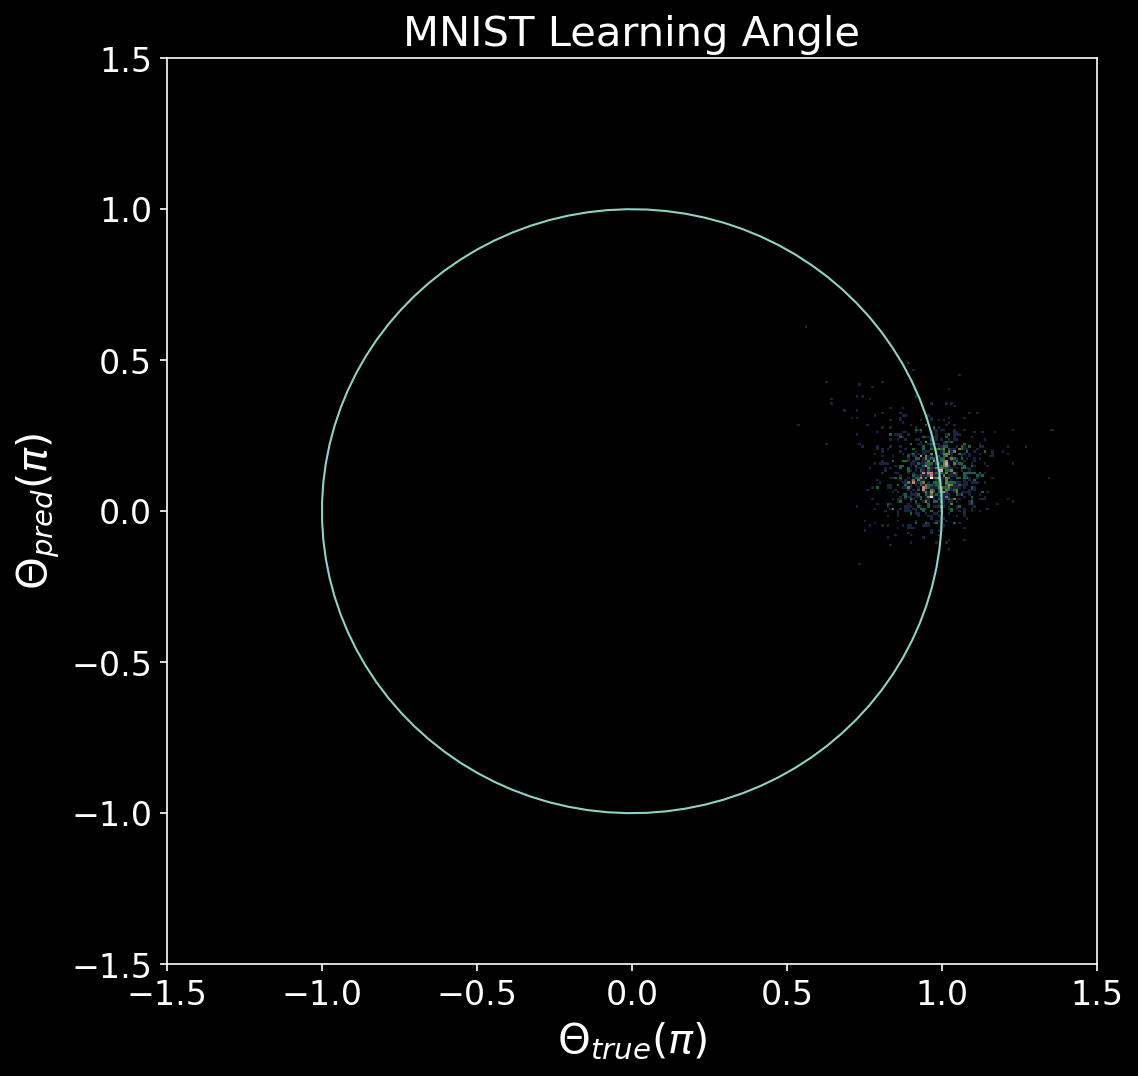

In [165]:
maskt = np.isin(angle_test[tst_slice],angle_test[0])

fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111) 
ax.hist2d(y_pred_test[maskt,0], y_pred_test[maskt,1],
          bins=[100,100],cmap='cubehelix')
plt.xlim([-1.5,1.5])
plt.ylim([-1.5,1.5])
t = np.linspace(0,np.pi*2,100)
ax.plot(np.cos(t), np.sin(t), linewidth=1)
plt.ylabel('$\Theta_{pred} (\pi)$')
plt.xlabel('$\Theta_{true} (\pi)$')
plt.title('MNIST Learning Angle')
plt.show()

In [172]:
i=4
sc = StandardScaler()
tr_slice = np.logical_and(np.isin(angle_test,angle_array[1:50:i]),np.isin(angle_class,2))
tst_slice = np.logical_and(~tr_slice,np.isin(angle_class,2))
X_tr = sc.fit_transform(np.log10(mnist_DHC_out_sizetest[tr_slice]))
Y_tr = np.array([np.cos(2*np.mod(angle_test[tr_slice],np.pi)),np.sin(2*np.mod(angle_test[tr_slice],np.pi))]).T
Y_test = np.array([np.cos(2*np.mod(angle_test[tst_slice],np.pi)),np.sin(2*np.mod(angle_test[tst_slice],np.pi))]).T
X_test = sc.transform(np.log10(mnist_DHC_out_sizetest[tst_slice]))

reg = LinearRegression().fit(X_tr, Y_tr)
y_pred_test = reg.predict(X_test)
y_pred_train = reg.predict(X_tr)
train_lossl2 = np.mean(np.square(y_pred_train-Y_tr))
test_lossl2 = np.mean(np.square(y_pred_test-Y_test))

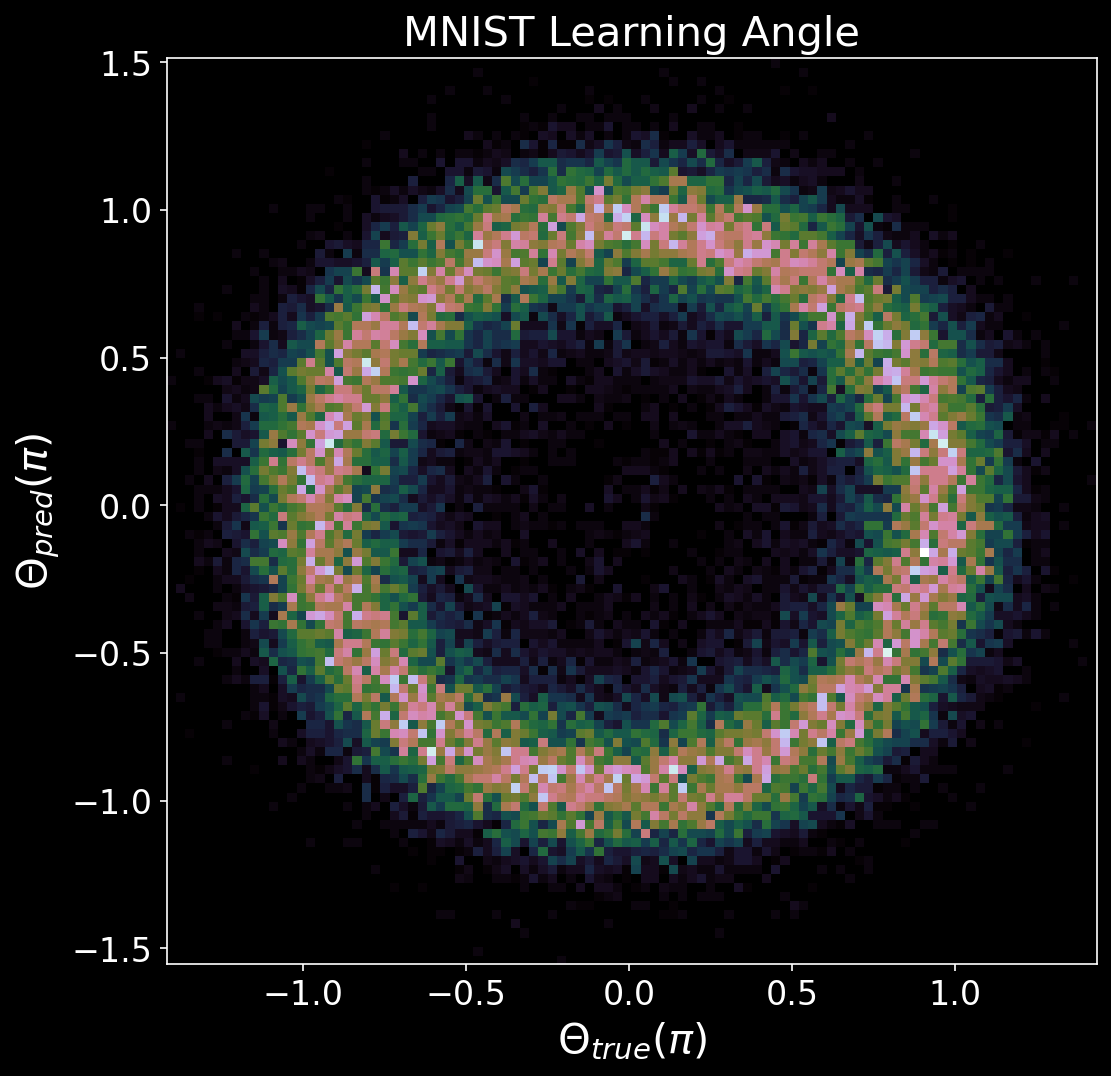

In [173]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111) 
#plt.scatter(Y_test,np.square(y_pred_test-Y_test),s=1)
ax.hist2d(y_pred_test[:,0], y_pred_test[:,1],
          bins=[100,100],cmap='cubehelix')
#plt.ylim([-1.1,1.1])
#for i in np.array((np.mod([2*np.pi/M,np.pi/3,2*np.pi/3,3*np.pi/3,4*np.pi/3,5*np.pi/3],np.pi)-0.5)/np.pi):
#    plt.vlines(i,-2,2,'w')

plt.ylabel('$\Theta_{pred} (\pi)$')
plt.xlabel('$\Theta_{true} (\pi)$')
plt.title('MNIST Learning Angle')
plt.show()

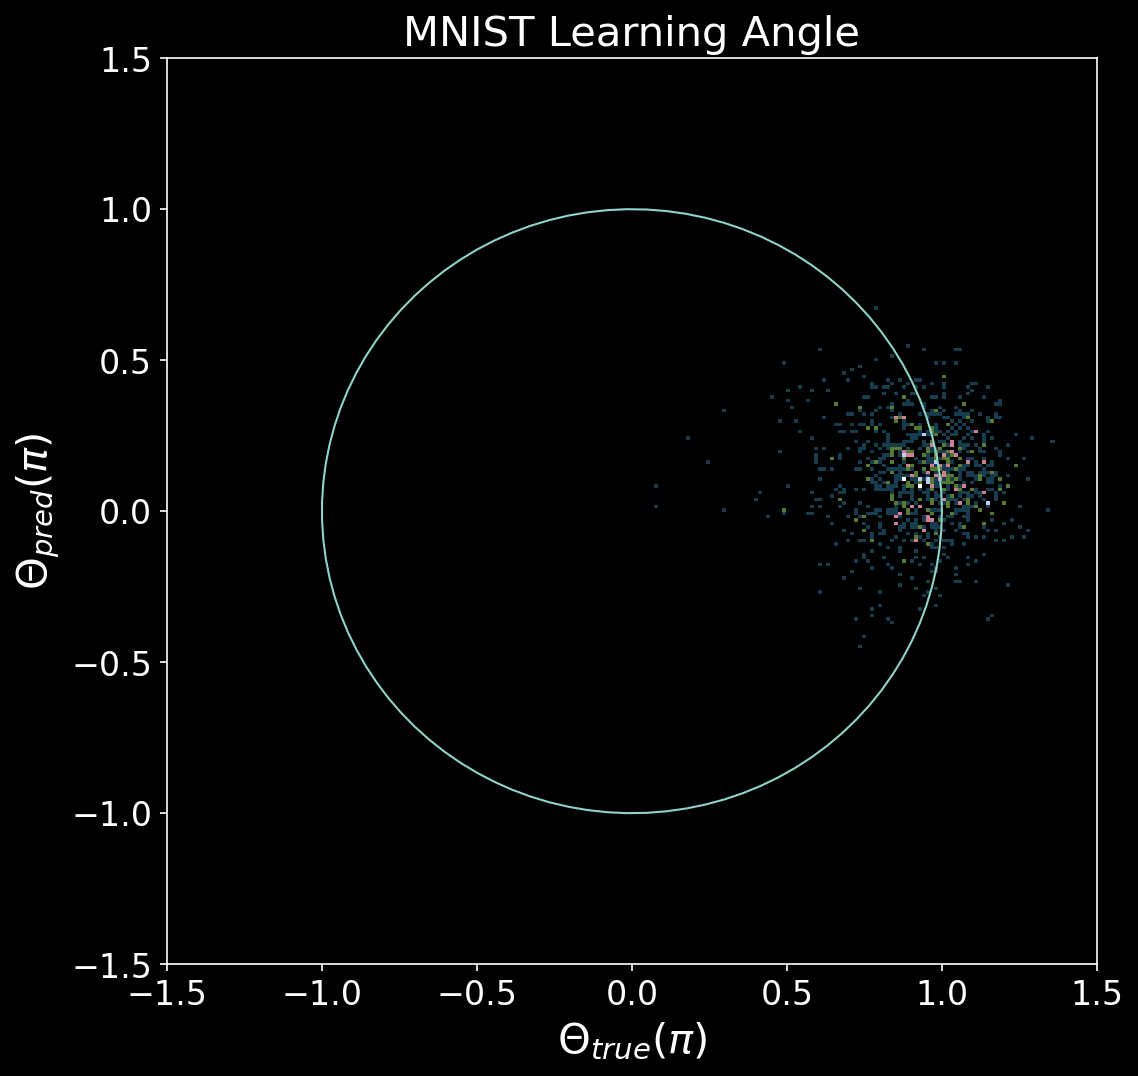

In [174]:
maskt = np.isin(angle_test[tst_slice],angle_test[0])

fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111) 
ax.hist2d(y_pred_test[maskt,0], y_pred_test[maskt,1],
          bins=[100,100],cmap='cubehelix')
plt.xlim([-1.5,1.5])
plt.ylim([-1.5,1.5])
t = np.linspace(0,np.pi*2,100)
ax.plot(np.cos(t), np.sin(t), linewidth=1)
plt.ylabel('$\Theta_{pred} (\pi)$')
plt.xlabel('$\Theta_{true} (\pi)$')
plt.title('MNIST Learning Angle')
plt.show()

So, I want a pipeline that tells me accuracy at a given angle for classes, accuracy of a given class for angles, and accuracy of doing both at the same time.

I want std of pdf of diff of angles when learning angles for all classes and sep by class. I can use this metric to evaluate the number of training angles needed and the behavior with L.

In [176]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LinearRegression

In [166]:
mnist_DHC_out_train_L4s = hd5_open('../from_cannon/2021_03_09/mnist_DHC_train_eq_L4_s.h5','main/data')
mnist_DHC_out_test_L4s = hd5_open('../from_cannon/2021_03_09/mnist_DHC_test_eq_L4_s.h5','main/data')

In [167]:
mnist_DHC_out_train_L4s_angles = hd5_open('../from_cannon/2021_03_09/mnist_DHC_train_eq_L4_s.h5','main/angles')
mnist_DHC_out_test_L4s_angles = hd5_open('../from_cannon/2021_03_09/mnist_DHC_test_eq_L4_s.h5','main/angles')

In [187]:
NtestAngle = mnist_DHC_out_test_L4s_angles.shape[0]
NtrainAngle = mnist_DHC_out_train_L4s_angles.shape[0]

angle_test = np.tile(mnist_DHC_out_test_L4s_angles,10000)
angle_test_class = np.repeat(mnist_test_y,NtestAngle)

angle_train = np.tile(mnist_DHC_out_train_L4s_angles,60000)
angle_train_class = np.repeat(mnist_train_y,NtrainAngle)

lb = LabelBinarizer()
train_y_onehot = lb.fit_transform(angle_train_class)

lb = LabelBinarizer()
test_y_onehot = lb.fit_transform(angle_test_class)

In [189]:
NTrainSubset = 12
idx = np.round(np.linspace(0, NtrainAngle - 1, 12)).astype(int)
sc = StandardScaler()
tr_slice = np.logical_and(np.isin(angle_train,mnist_DHC_out_train_L4s_angles[idx]),np.isin(angle_train_class,2))
tst_slice = np.isin(angle_test_class,2)

X_tr = sc.fit_transform(np.log10(mnist_DHC_out_train_L4s[tr_slice]))
Y_tr = np.array([
    np.cos(2*np.mod(angle_train[tr_slice],np.pi)),
    np.sin(2*np.mod(angle_train[tr_slice],np.pi)),
]).T

X_test = sc.transform(np.log10(mnist_DHC_out_test_L4s[tst_slice]))
Y_test = np.array([
    np.cos(2*np.mod(angle_test[tst_slice],np.pi)),
    np.sin(2*np.mod(angle_test[tst_slice],np.pi))
]).T

reg = LinearRegression().fit(X_tr, Y_tr)
y_pred_test = reg.predict(X_test)
y_pred_train = reg.predict(X_tr)

train_lossl2 = np.mean(np.square(y_pred_train-Y_tr))
test_lossl2 = np.mean(np.square(y_pred_test-Y_test))

Pretty impressive for L=4

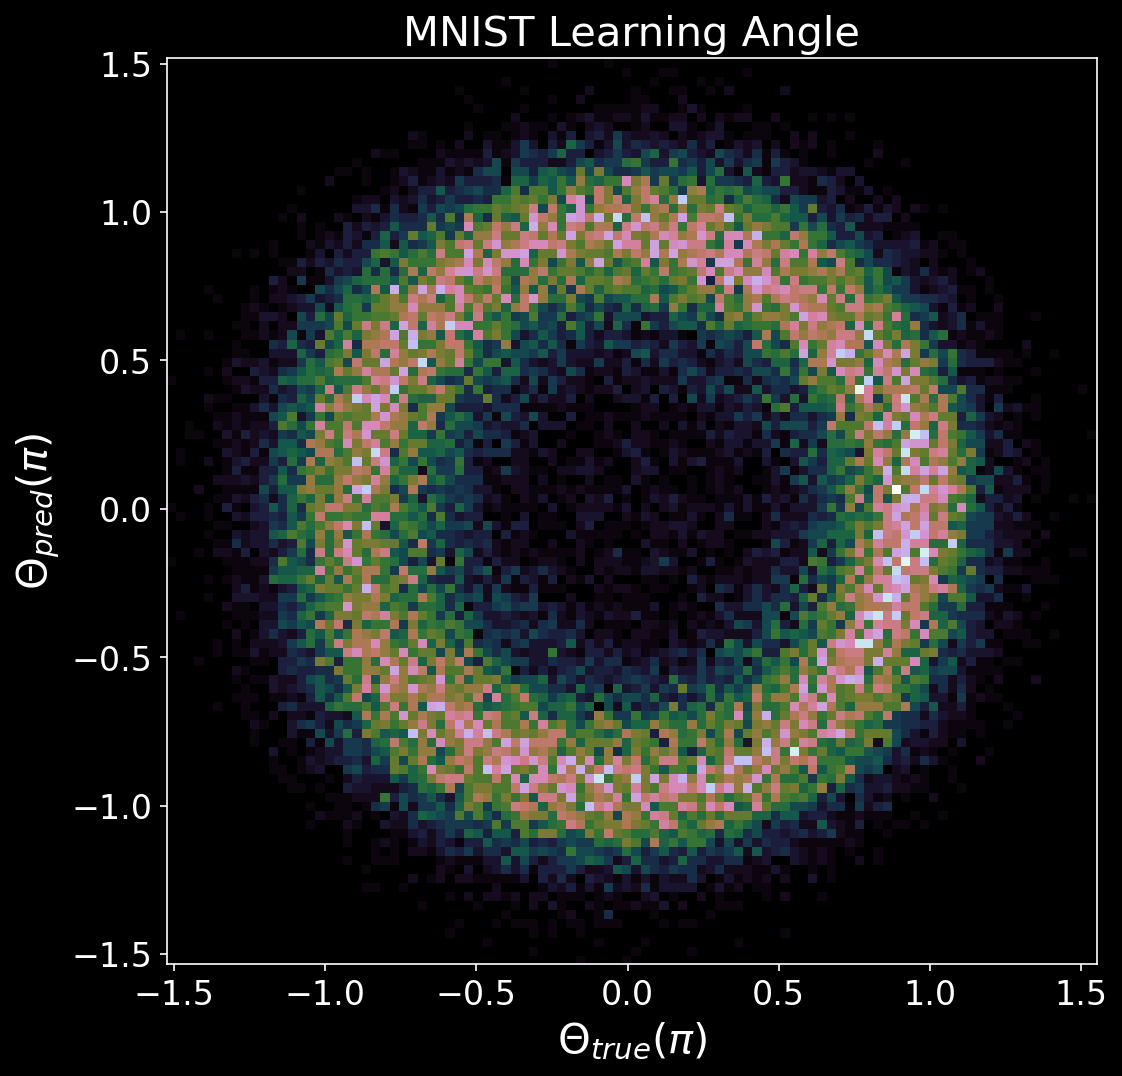

In [192]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111) 
#plt.scatter(Y_test,np.square(y_pred_test-Y_test),s=1)
ax.hist2d(y_pred_test[:,0], y_pred_test[:,1],
          bins=[100,100],cmap='cubehelix')
#plt.ylim([-1.1,1.1])
#for i in np.array((np.mod([2*np.pi/M,np.pi/3,2*np.pi/3,3*np.pi/3,4*np.pi/3,5*np.pi/3],np.pi)-0.5)/np.pi):
#    plt.vlines(i,-2,2,'w')

plt.ylabel('$\Theta_{pred} (\pi)$')
plt.xlabel('$\Theta_{true} (\pi)$')
plt.title('MNIST Learning Angle')
plt.show()

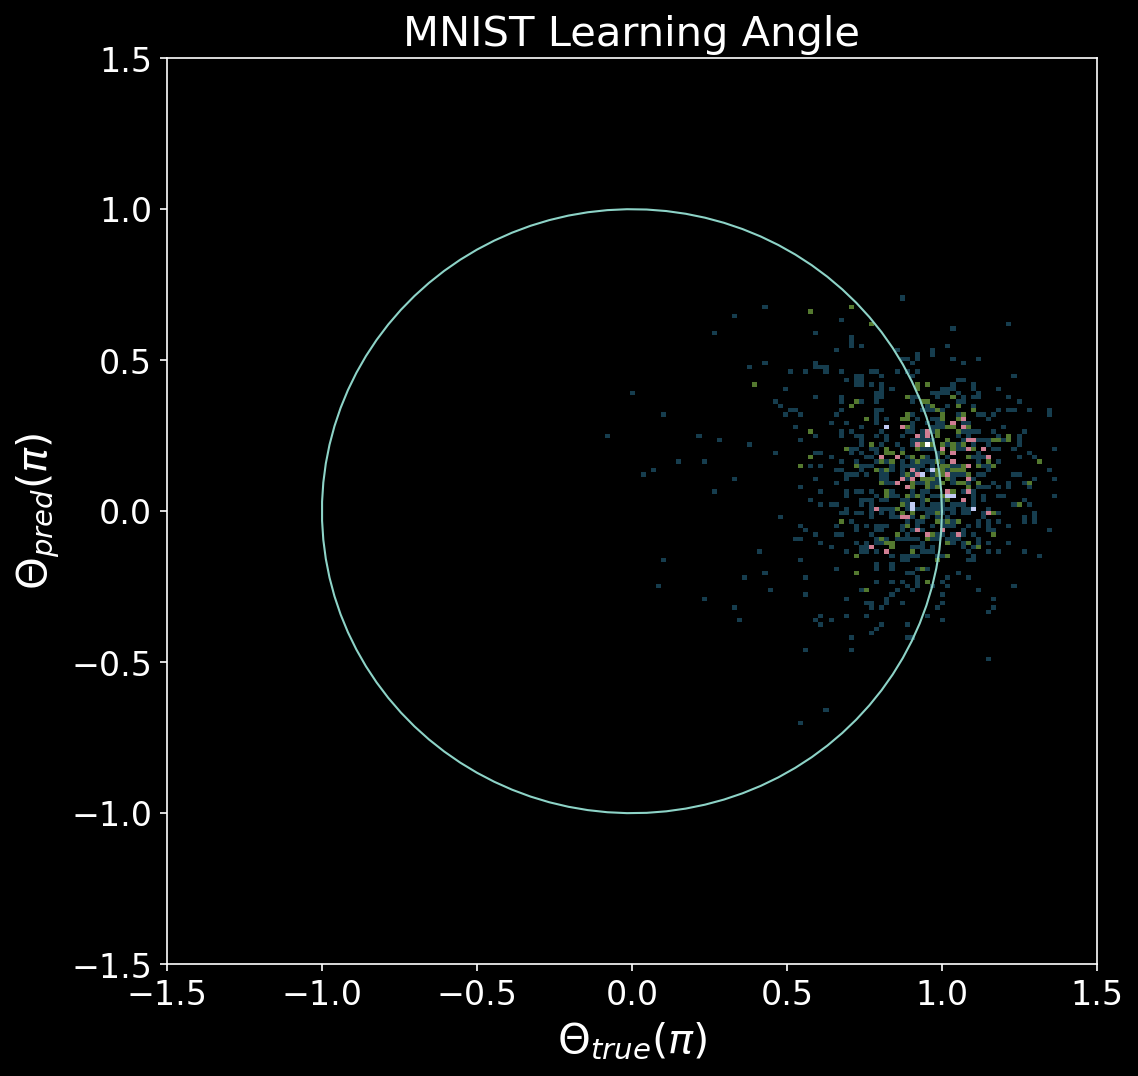

In [193]:
maskt = np.isin(angle_test[tst_slice],mnist_DHC_out_test_L4s_angles[0])

fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111) 
ax.hist2d(y_pred_test[maskt,0], y_pred_test[maskt,1],
          bins=[100,100],cmap='cubehelix')
plt.xlim([-1.5,1.5])
plt.ylim([-1.5,1.5])
t = np.linspace(0,np.pi*2,100)
ax.plot(np.cos(t), np.sin(t), linewidth=1)
plt.ylabel('$\Theta_{pred} (\pi)$')
plt.xlabel('$\Theta_{true} (\pi)$')
plt.title('MNIST Learning Angle')
plt.show()

In [194]:
from tqdm import tqdm

In [197]:
NTrainSubset_list = [2,4,8,12,16,20,24]
std_class = np.zeros((len(NTrainSubset_list),10,3))
for i in range(len(NTrainSubset_list)):
    for j in tqdm(range(10)):
        NTrainSubset = NTrainSubset_list[i]
        idx = np.round(np.linspace(0, NtrainAngle - 1, NTrainSubset)).astype(int)

        sc = StandardScaler()
        tr_slice = np.logical_and(np.isin(angle_train,mnist_DHC_out_train_L4s_angles[idx]),np.isin(angle_train_class,j))
        tst_slice = np.isin(angle_test_class,j)

        X_tr = sc.fit_transform(np.log10(mnist_DHC_out_train_L4s[tr_slice]))
        Y_tr = np.array([
            np.cos(2*np.mod(angle_train[tr_slice],np.pi)),
            np.sin(2*np.mod(angle_train[tr_slice],np.pi)),
        ]).T

        X_test = sc.transform(np.log10(mnist_DHC_out_test_L4s[tst_slice]))
        Y_test = np.array([
            np.cos(2*np.mod(angle_test[tst_slice],np.pi)),
            np.sin(2*np.mod(angle_test[tst_slice],np.pi))
        ]).T

        reg = LinearRegression().fit(X_tr, Y_tr)
        y_pred_test = reg.predict(X_test)
        y_pred_train = reg.predict(X_tr)

        train_lossl2 = np.mean(np.square(y_pred_train-Y_tr))
        test_lossl2 = np.mean(np.square(y_pred_test-Y_test))

        std_class[i,j,0] = train_lossl2
        std_class[i,j,1] = test_lossl2
        
        diff = 180*(np.arctan2(Y_test[:,1],Y_test[:,0])/np.pi-np.arctan2(y_pred_test[:,1],y_pred_test[:,0])/np.pi)
        diff[diff<-180]+=360
        diff[diff>180]-=360

        std_class[i,j,2] = np.std(diff)

100%|██████████| 10/10 [01:10<00:00,  7.04s/it]


(10.0, 50.0)

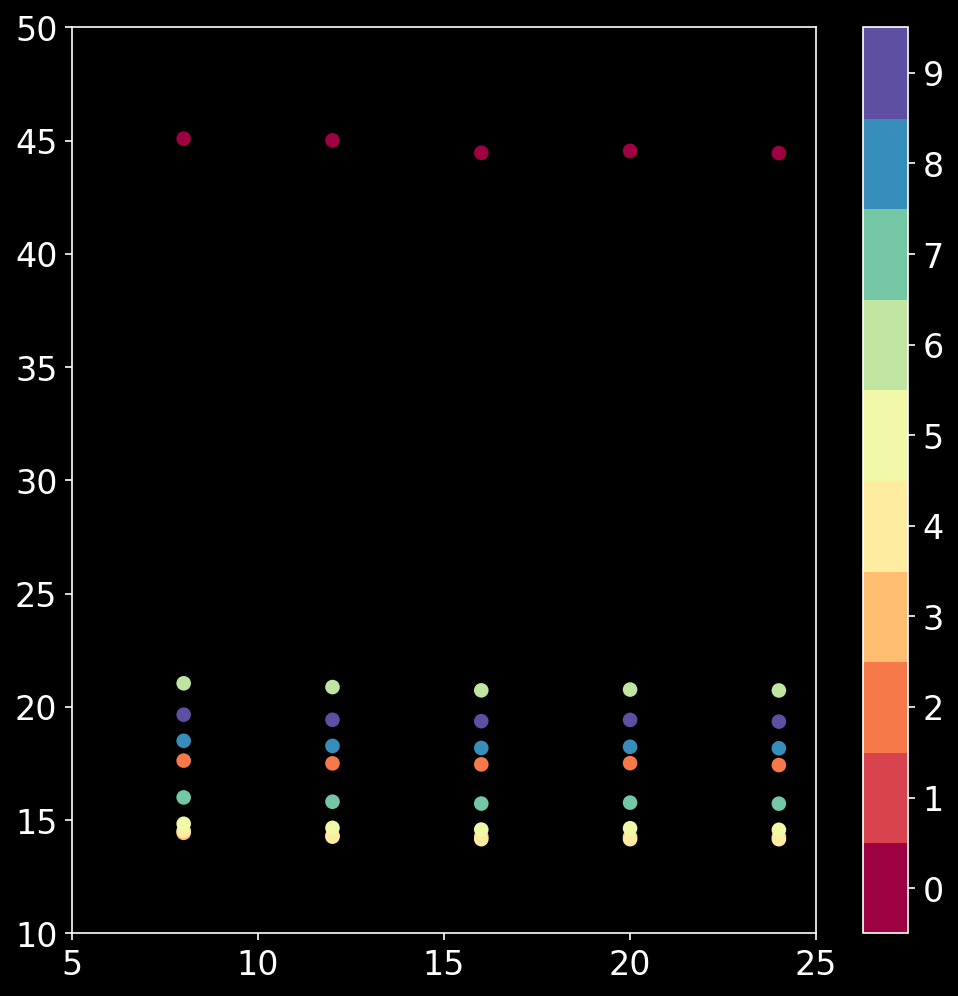

In [205]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111)
for i in range(10):
    sc = ax.scatter(NTrainSubset_list,std_class[:,i,2],c=i*np.ones(len(NTrainSubset_list)),cmap='Spectral',vmin=0,vmax=9)
plt.colorbar(sc,boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.xlim([5,25])
plt.ylim([10,50])

In [231]:
def cm_eval(y_pred, y_true,n_classes):
    cm = np.zeros((n_classes,n_classes))
    for indx in range(y_pred.shape[0]):
        cm[y_true[indx],y_pred[indx]] += 1
    return cm.astype(int)

In [222]:
NTrainSubset_list = [2,4,8,12,16,20,24]
std_class_both = np.zeros((len(NTrainSubset_list),10,6))
for i in tqdm(range(len(NTrainSubset_list))):
    NTrainSubset = NTrainSubset_list[i]
    idx = np.round(np.linspace(0, NtrainAngle - 1, NTrainSubset)).astype(int)

    sc = StandardScaler()
    tr_slice = np.isin(angle_train,mnist_DHC_out_train_L4s_angles[idx])
    tst_slice = np.isin(angle_test_class,[0,1,2,3,4,5,6,7,8,9])

    X_tr = sc.fit_transform(np.log10(mnist_DHC_out_train_L4s[tr_slice]))
    Y_tr = np.array([
        np.cos(2*np.mod(angle_train[tr_slice],np.pi)),
        np.sin(2*np.mod(angle_train[tr_slice],np.pi)),
    ]).T
    Y_tr = np.hstack((train_y_onehot[tr_slice],Y_tr))

    X_test = sc.transform(np.log10(mnist_DHC_out_test_L4s[tst_slice]))
    Y_test = np.array([
        np.cos(2*np.mod(angle_test[tst_slice],np.pi)),
        np.sin(2*np.mod(angle_test[tst_slice],np.pi))
    ]).T
    Y_test = np.hstack((test_y_onehot[tst_slice],Y_test))

    reg = LinearRegression().fit(X_tr, Y_tr)
    y_pred_test = reg.predict(X_test)
    y_pred_train = reg.predict(X_tr)

    train_lossl2 = np.square(y_pred_train-Y_tr)
    test_lossl2 = np.square(y_pred_test-Y_test)

    diff = 180*(np.arctan2(Y_test[:,1],Y_test[:,0])/np.pi-np.arctan2(y_pred_test[:,1],y_pred_test[:,0])/np.pi)
    diff[diff<-180]+=360
    diff[diff>180]-=360
    
    class_pred = np.argmax(y_pred_test[:,2:],axis=1)
    cmat = cm_eval(class_pred,angle_test_class[tst_slice],10)

    for j in range(10):
        masktst = np.isin(angle_test_class[tst_slice],j)
        masktr = np.isin(angle_train_class[tr_slice],j)
        std_class_both[i,j,0] = np.mean(train_lossl2[masktr,0:2])
        std_class_both[i,j,1] = np.mean(test_lossl2[maskt,0:2])
        std_class_both[i,j,2] = np.mean(train_lossl2[masktr,2+j])
        std_class_both[i,j,3] = np.mean(test_lossl2[maskt,2+j])             
        std_class_both[i,j,4] = np.std(diff[maskt])
        std_class_both[i,j,5] = cmat[j,j]/np.count_nonzero(maskt)

100%|██████████| 7/7 [06:34<00:00, 56.34s/it]


In [244]:
diff[maskt].shape

(47040,)

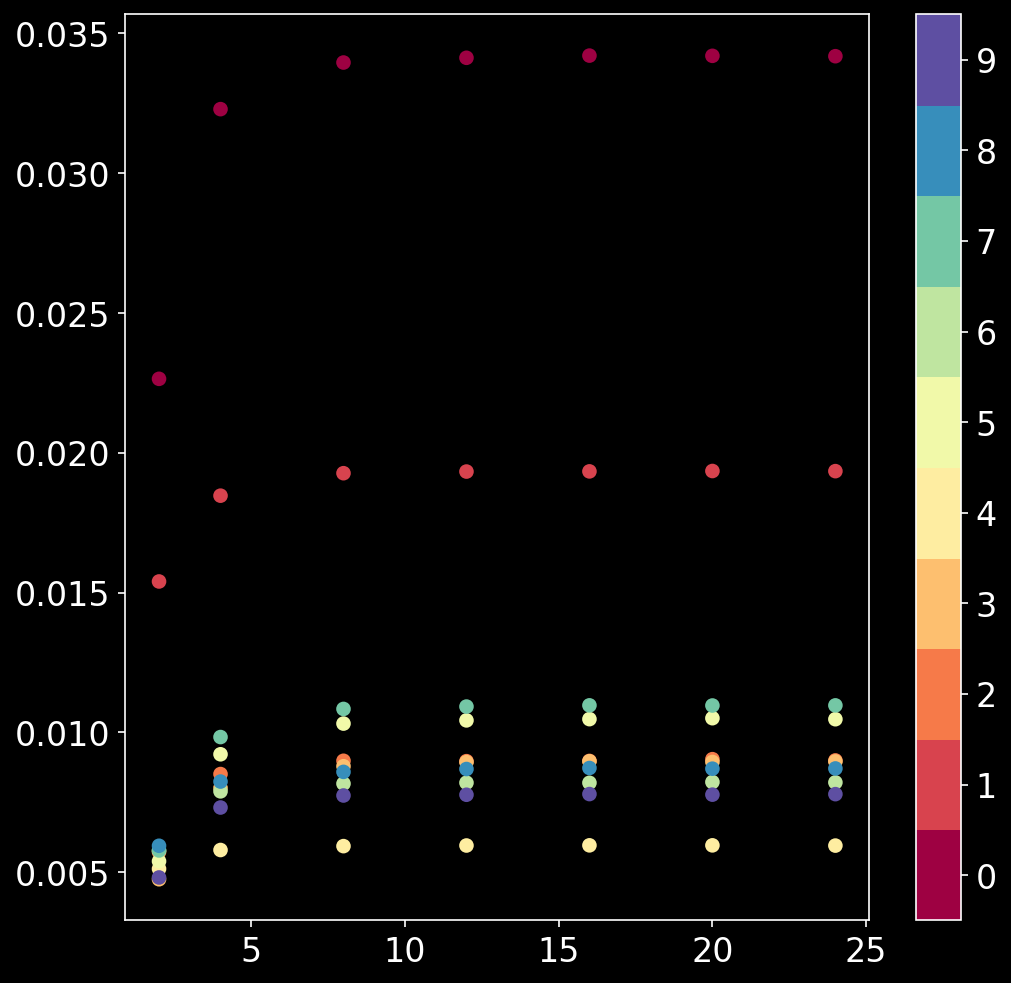

In [238]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111)
for i in range(10):
    sc = ax.scatter(NTrainSubset_list,std_class_both[:,i,0],c=i*np.ones(len(NTrainSubset_list)),cmap='Spectral',vmin=0,vmax=9)
plt.colorbar(sc,boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))

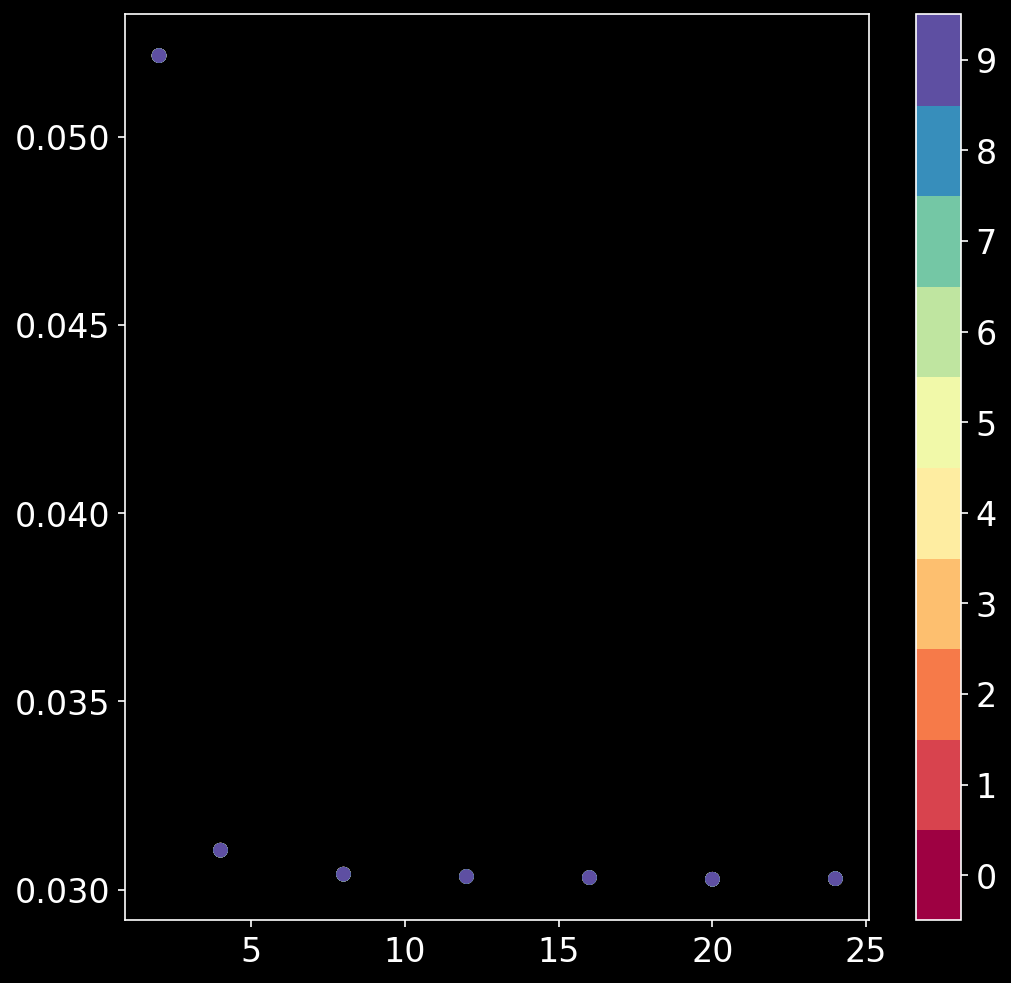

In [239]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111)
for i in range(10):
    sc = ax.scatter(NTrainSubset_list,std_class_both[:,i,1],c=i*np.ones(len(NTrainSubset_list)),cmap='Spectral',vmin=0,vmax=9)
plt.colorbar(sc,boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))

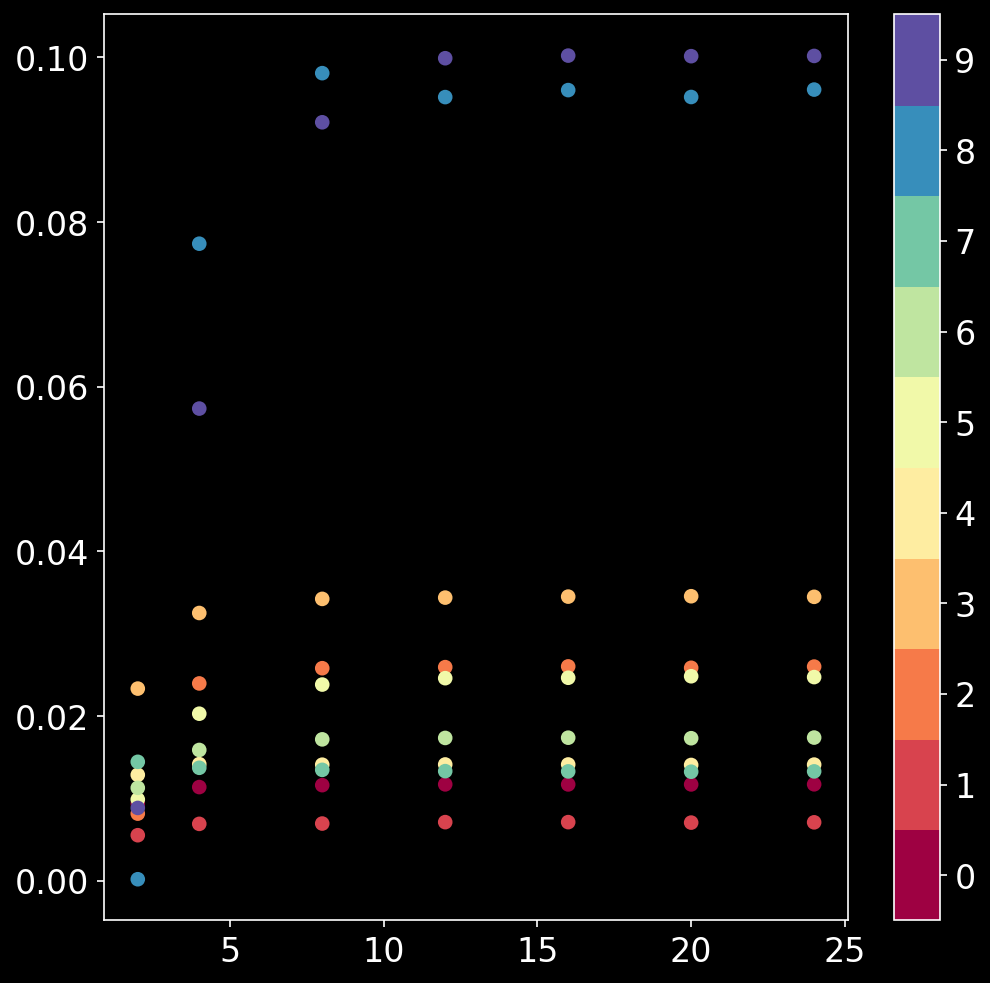

In [240]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111)
for i in range(10):
    sc = ax.scatter(NTrainSubset_list,std_class_both[:,i,2],c=i*np.ones(len(NTrainSubset_list)),cmap='Spectral',vmin=0,vmax=9)
plt.colorbar(sc,boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))

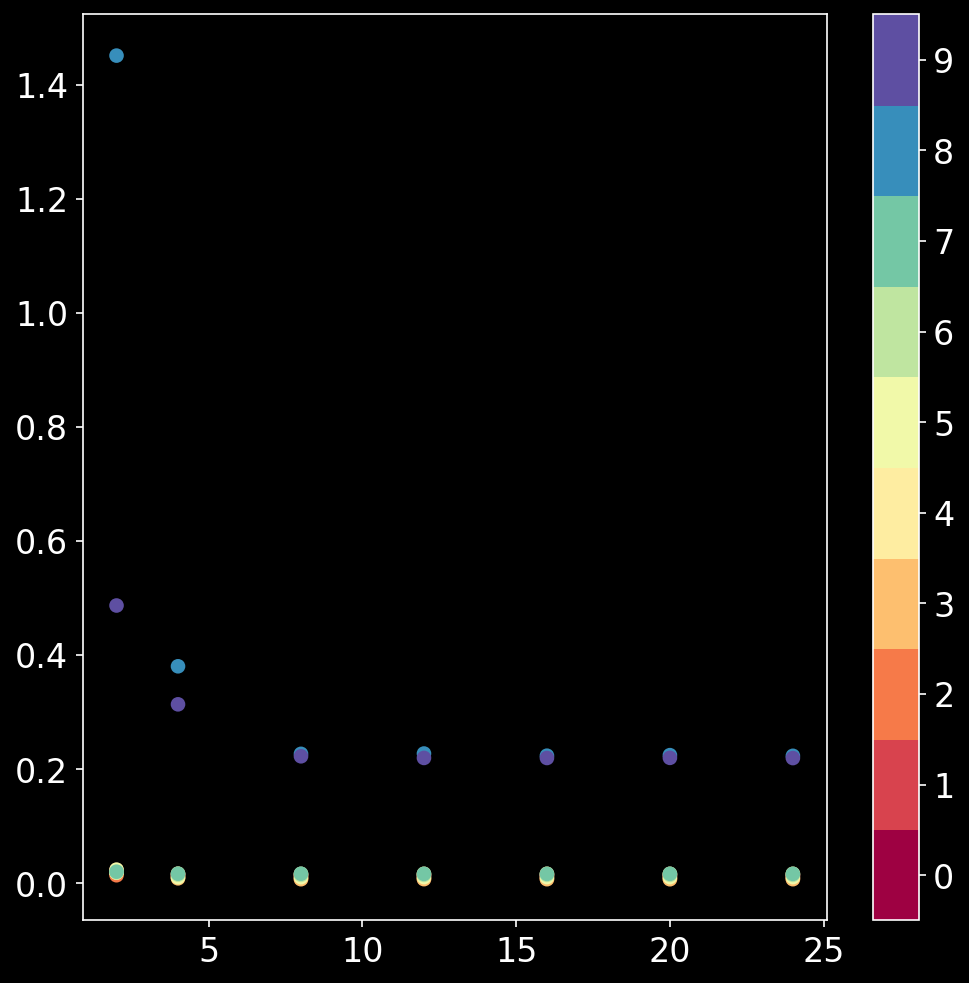

In [241]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111)
for i in range(10):
    sc = ax.scatter(NTrainSubset_list,std_class_both[:,i,3],c=i*np.ones(len(NTrainSubset_list)),cmap='Spectral',vmin=0,vmax=9)
plt.colorbar(sc,boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))

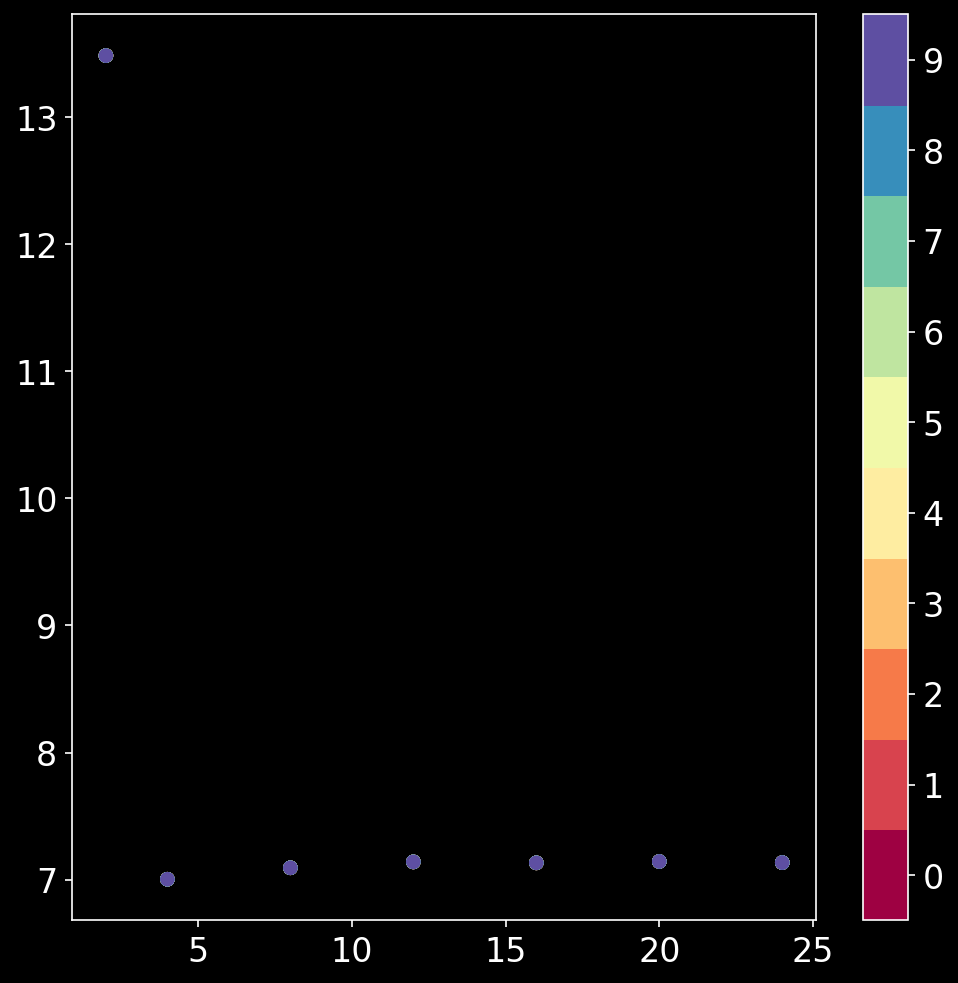

In [242]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111)
for i in range(10):
    sc = ax.scatter(NTrainSubset_list,std_class_both[:,i,4],c=i*np.ones(len(NTrainSubset_list)),cmap='Spectral',vmin=0,vmax=9)
plt.colorbar(sc,boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))

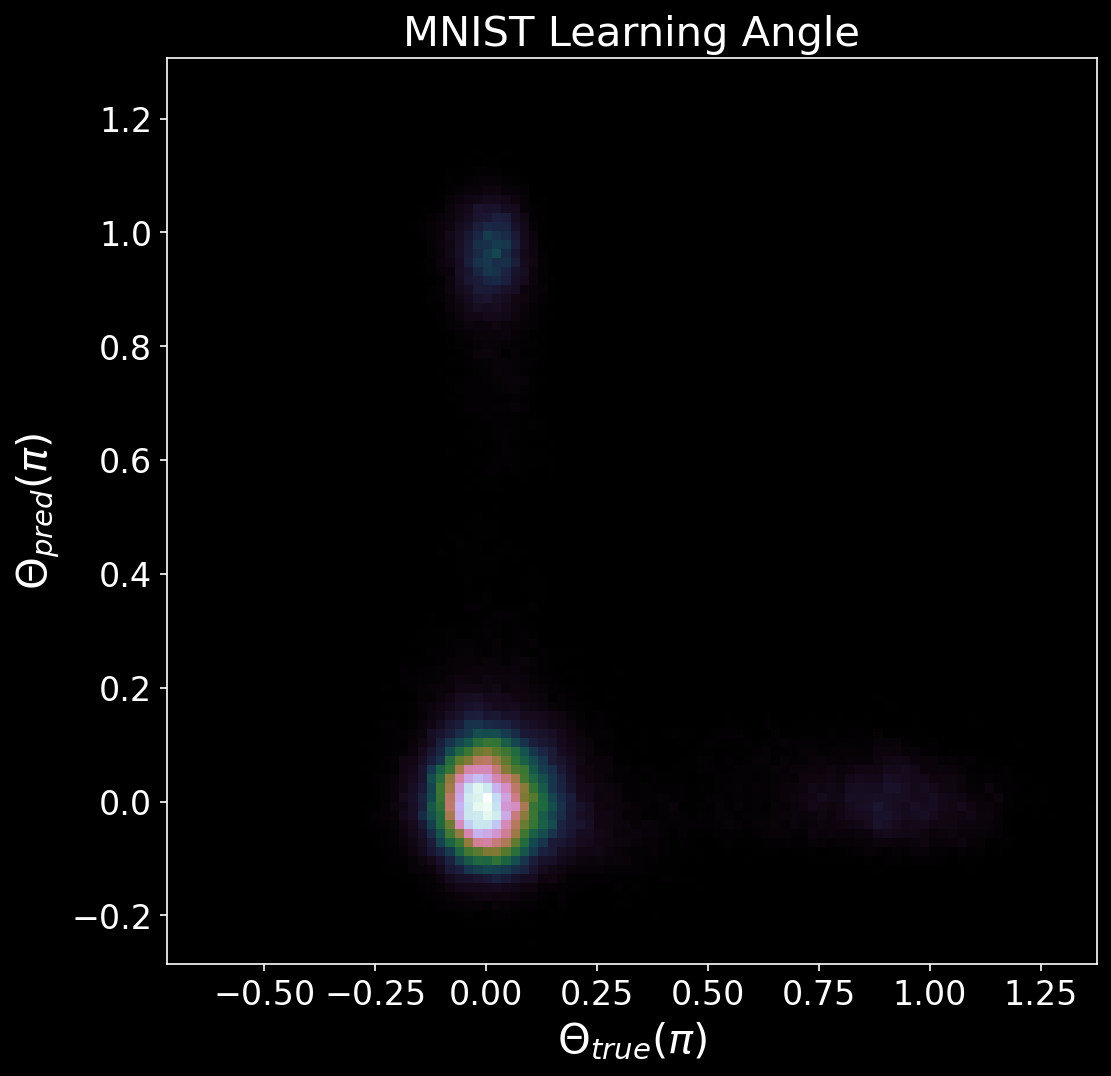

In [245]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111) 
#plt.scatter(Y_test,np.square(y_pred_test-Y_test),s=1)
ax.hist2d(y_pred_test[:,0], y_pred_test[:,1],
          bins=[100,100],cmap='cubehelix')
#plt.ylim([-1.1,1.1])
#for i in np.array((np.mod([2*np.pi/M,np.pi/3,2*np.pi/3,3*np.pi/3,4*np.pi/3,5*np.pi/3],np.pi)-0.5)/np.pi):
#    plt.vlines(i,-2,2,'w')

plt.ylabel('$\Theta_{pred} (\pi)$')
plt.xlabel('$\Theta_{true} (\pi)$')
plt.title('MNIST Learning Angle')
plt.show()

In [246]:
NTrainSubset_list = [2,4,8,12,16]
std_class_both2 = np.zeros((len(NTrainSubset_list),10,6))
for i in tqdm(range(len(NTrainSubset_list))):
    NTrainSubset = NTrainSubset_list[i]
    idx = np.round(np.linspace(0, NtrainAngle - 1, NTrainSubset)).astype(int)

    sc = StandardScaler()
    tr_slice = np.isin(angle_train,mnist_DHC_out_train_L4s_angles[idx])
    tst_slice = np.isin(angle_test_class,[0,1,2,3,4,5,6,7,8,9])

    X_tr = sc.fit_transform(np.log10(mnist_DHC_out_train_L4s[tr_slice]))
    Y_tr = np.array([
        np.cos(2*np.mod(angle_train[tr_slice],np.pi)),
        np.sin(2*np.mod(angle_train[tr_slice],np.pi)),
    ]).T
    #Y_tr = np.hstack((train_y_onehot[tr_slice],Y_tr))

    X_test = sc.transform(np.log10(mnist_DHC_out_test_L4s[tst_slice]))
    Y_test = np.array([
        np.cos(2*np.mod(angle_test[tst_slice],np.pi)),
        np.sin(2*np.mod(angle_test[tst_slice],np.pi))
    ]).T
    #Y_test = np.hstack((test_y_onehot[tst_slice],Y_test))

    reg = LinearRegression().fit(X_tr, Y_tr)
    y_pred_test = reg.predict(X_test)
    y_pred_train = reg.predict(X_tr)

    train_lossl2 = np.square(y_pred_train-Y_tr)
    test_lossl2 = np.square(y_pred_test-Y_test)

    diff = 180*(np.arctan2(Y_test[:,1],Y_test[:,0])/np.pi-np.arctan2(y_pred_test[:,1],y_pred_test[:,0])/np.pi)
    diff[diff<-180]+=360
    diff[diff>180]-=360
    
    #class_pred = np.argmax(y_pred_test[:,2:],axis=1)
    #cmat = cm_eval(class_pred,angle_test_class[tst_slice],10)

    for j in range(10):
        masktst = np.isin(angle_test_class[tst_slice],j)
        masktr = np.isin(angle_train_class[tr_slice],j)
        std_class_both2[i,j,0] = np.mean(train_lossl2[masktr,0:2])
        std_class_both2[i,j,1] = np.mean(test_lossl2[maskt,0:2])
        #std_class_both2[i,j,2] = np.mean(train_lossl2[masktr,2+j])
        #std_class_both2[i,j,3] = np.mean(test_lossl2[maskt,2+j])             
        std_class_both2[i,j,4] = np.std(diff[maskt])
        #std_class_both2[i,j,5] = cmat[j,j]/np.count_nonzero(maskt)

100%|██████████| 5/5 [03:27<00:00, 41.49s/it]


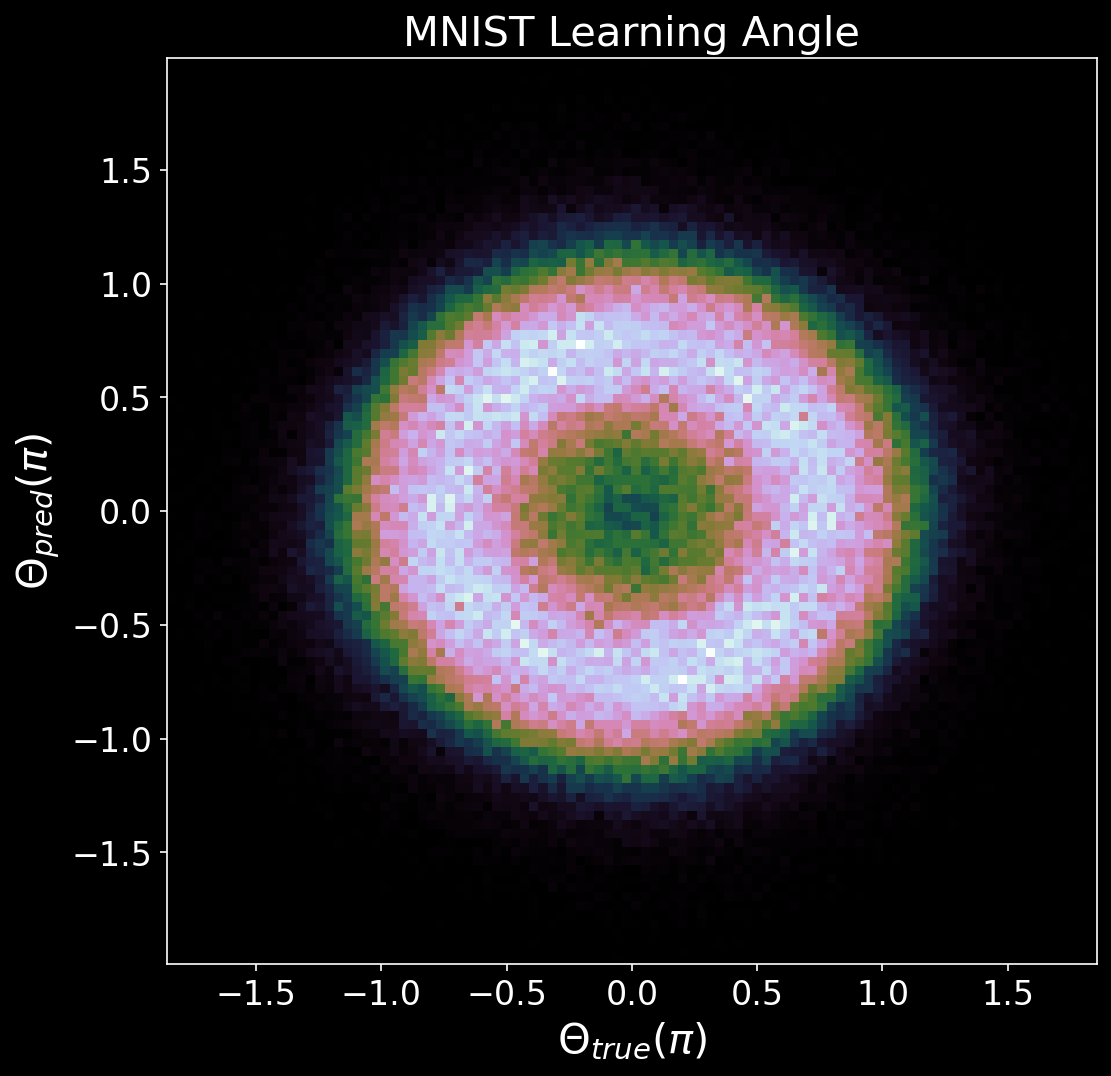

In [247]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111) 
#plt.scatter(Y_test,np.square(y_pred_test-Y_test),s=1)
ax.hist2d(y_pred_test[:,0], y_pred_test[:,1],
          bins=[100,100],cmap='cubehelix')
#plt.ylim([-1.1,1.1])
#for i in np.array((np.mod([2*np.pi/M,np.pi/3,2*np.pi/3,3*np.pi/3,4*np.pi/3,5*np.pi/3],np.pi)-0.5)/np.pi):
#    plt.vlines(i,-2,2,'w')

plt.ylabel('$\Theta_{pred} (\pi)$')
plt.xlabel('$\Theta_{true} (\pi)$')
plt.title('MNIST Learning Angle')
plt.show()

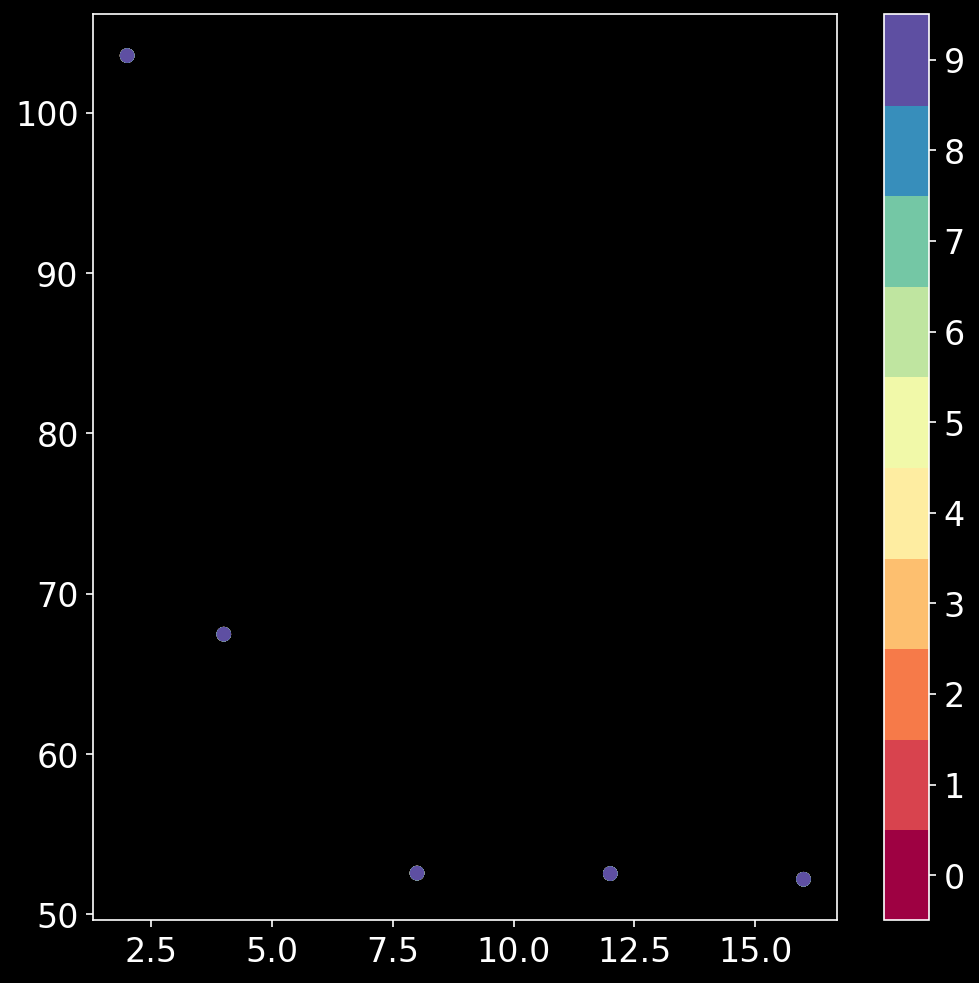

In [249]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111)
for i in range(10):
    sc = ax.scatter(NTrainSubset_list,std_class_both2[:,i,4],c=i*np.ones(len(NTrainSubset_list)),cmap='Spectral',vmin=0,vmax=9)
plt.colorbar(sc,boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))

I can believe this second result. Need to run down what settings in the "linear regression" are such that this is not the same as the first result. Only getting pi/L performance, especially when doing all of the digits together, is a fine answer. I just need to understand why I could not do it at the same time as the one-hot encoding. Then I just need to learn the class at a few fixed angles and average over those angles so we have an estimate of all 3 cases.